In [3]:
import numpy as np
import matplotlib.pyplot as plt

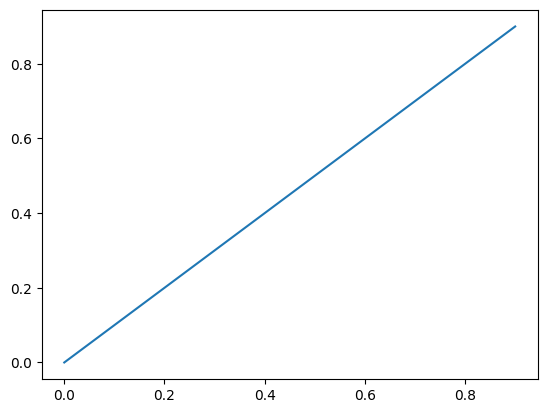

In [4]:
%matplotlib inline
plt.plot(np.arange(0, 1, 0.1), np.arange(0, 1, 0.1))

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import nn, optim


In [6]:
from scipy import stats
import time

In [164]:
epochs = 100
rTrain = 0.7;
rTest = 0.2;
# input_vector_length = 100
batch_size = 32
num_bins = 40
coef_delta = 0

In [232]:
# epochs = 400
# test_sample_ratio = .2
# validation_sample_ratio = 0.1
# batch_size = 32
# coef_delta = 0

# noise_ratio = 0.9
# bbh_ratio = 0.1


In [8]:
os.chdir('D:\OneDrive - HKUST Connect\Research\GWNMMAD\Codes')

## Data preparation

In [168]:
renorm_factor = 20;

realbkg = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/background.npz")['data'] / renorm_factor;
realbbh = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/bbh_for_challenge.npy") / renorm_factor;

realsg = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/sglf_for_challenge.npy") / renorm_factor;

In [169]:
realglitch = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"] / 12.3

We only care about pattern, so we center each input to 0 by subtracting its mean, and renormalize by dividing over $\sigma$

In [170]:
realbkg_trimmed = realbkg[:, 0];
realbbh_trimmed = realbbh[:, 0];
realsg_trimmed  = realsg[:, 0];

realbkg_trimmed = (realbkg_trimmed - np.transpose([np.mean(realbkg_trimmed, axis=1)]))/np.transpose([np.std(realbkg_trimmed, axis=1)]);
realbbh_trimmed = (realbbh_trimmed - np.transpose([np.mean(realbbh_trimmed, axis=1)]))/np.transpose([np.std(realbbh_trimmed, axis=1)]);
realsg_trimmed  = (realsg_trimmed  - np.transpose([np.mean(realsg_trimmed , axis=1)]))/np.transpose([np.std(realsg_trimmed,  axis=1)]);

In [171]:
realglitch_trimmed = (realglitch - np.transpose([np.mean(realglitch, axis=1)]))/np.transpose([np.std(realglitch, axis=1)])

In [172]:
realbkg_trimmed = abs(np.fft.rfft(realbkg_trimmed))
realbbh_trimmed = abs(np.fft.rfft(realbbh_trimmed))
realsg_trimmed = abs(np.fft.rfft(realsg_trimmed))
realglitch_trimmed = abs(np.fft.rfft(realglitch_trimmed))

realbkg_trimmed = realbkg_trimmed / np.linalg.norm(realbkg_trimmed, axis = 1).reshape(-1,1)
realbbh_trimmed = realbbh_trimmed / np.linalg.norm(realbbh_trimmed, axis = 1).reshape(-1,1)
realsg_trimmed = realsg_trimmed / np.linalg.norm(realsg_trimmed, axis = 1).reshape(-1,1)
realglitch_trimmed = realglitch_trimmed / np.linalg.norm(realglitch_trimmed, axis = 1).reshape(-1,1)

In [173]:
realbkg_trimmed.shape

(100000, 101)

In [174]:
dInput = realbkg_trimmed.shape[1]

In [7]:
# nTotal = len(bkg);
nTotal = len(realbbh_trimmed);
nTrain = int(rTrain * nTotal)
nTest  = int(rTest * nTotal)
nValid = nTotal - nTrain - nTest;

nTrain_g = int(rTrain * len(realglitch_trimmed))
nTest_g  = int(rTest  * len(realglitch_trimmed))
nValid_g = len(realglitch_trimmed) - nTrain_g - nTest_g;

X_train = np.empty((3*nTrain + nTrain_g, dInput))
X_test  = np.empty((3*nTest + nTest_g,  dInput))
X_valid = np.empty((3*nValid + nValid_g, dInput))

target_train = np.zeros((3*nTrain + nTrain_g,), dtype="int64")
target_test  = np.zeros((3*nTest + nTest_g, ), dtype="int64")
target_valid = np.zeros((3*nValid + nValid_g,), dtype="int64")

permBKG = np.random.permutation(nTotal)
permBBH = np.random.permutation(nTotal)
permSG  = np.random.permutation(nTotal)
permGLITCH = np.random.permutation(len(realglitch_trimmed))

np.savetxt("../Data_cached/SupLearn/perm_BKG.dat", permBKG)
np.savetxt("../Data_cached/SupLearn/perm_BBH.dat", permBBH)
np.savetxt("../Data_cached/SupLearn/perm_SG.dat", permSG)
np.savetxt("../Data_cached/SupLearn/perm_GLITCH.dat", permGLITCH)

# initializing the training set
X_train[:nTrain] = realbkg_trimmed[permBKG[:nTrain]]
X_train[nTrain:2*nTrain] = realbbh_trimmed[permBBH[:nTrain]]
X_train[2*nTrain:3*nTrain] = realsg_trimmed[permSG[:nTrain]]
X_train[3*nTrain:] = realglitch_trimmed[permGLITCH[:nTrain_g]]

target_train[:nTrain] = 1;
target_train[nTrain:2*nTrain] = 2;
target_train[2*nTrain:3*nTrain] = 3;

# initializing the test set
X_test[:nTest] = realbkg_trimmed[permBKG[-nTest:]]
X_test[nTest:2*nTest] = realbbh_trimmed[permBBH[-nTest:]]
X_test[2*nTest:3*nTest] = realsg_trimmed[permSG[-nTest:]]
X_test[3*nTest:] = realglitch_trimmed[permGLITCH[-nTest_g:]]

target_test[:nTest] = 1;
target_test[nTest:2*nTest] = 2;
target_test[2*nTest:3*nTest] = 3;

# initializing the validation set
X_valid[:nValid] = realbkg_trimmed[permBKG[nTrain:-nTest]]
X_valid[nValid:2*nValid] = realbbh_trimmed[permBBH[nTrain:-nTest]]
X_valid[2*nValid:3*nValid] = realsg_trimmed[permSG[nTrain:-nTest]]
X_valid[3*nValid:] = realglitch_trimmed[permGLITCH[nTrain_g:-nTest_g]]

target_valid[:nValid] = 1;
target_valid[nValid:2*nValid] = 2;
target_valid[2*nValid:3*nValid] = 3;

train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.tensor(target_train))
test_dataset  = TensorDataset(torch.FloatTensor(X_test),  torch.tensor(target_test))
valid_dataset = TensorDataset(torch.FloatTensor(X_valid), torch.tensor(target_valid))

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)

# X_train = realbbh_trimmed[perm[:nTrain]]
# X_test = realbbh_trimmed[perm[-nTest:]]
# X_validation = realbbh_trimmed[perm[nTrain:-nTest]]

# trainData = torch.FloatTensor(X_train)
# testData = torch.FloatTensor(X_test)
# validationData = torch.FloatTensor(X_validation)

# train_dataset = TensorDataset(trainData, trainData)
# test_dataset = TensorDataset(testData, testData)
# validation_dataset = TensorDataset(validationData, validationData)

# trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

NameError: name 'realbbh_trimmed' is not defined

In [175]:
# nTotal = len(bkg);
nTotal = len(realbbh_trimmed);
nTrain = int(rTrain * nTotal)
nTest  = int(rTest * nTotal)
nValid = nTotal - nTrain - nTest;

nTrain_g = int(rTrain * len(realglitch_trimmed))
nTest_g  = int(rTest  * len(realglitch_trimmed))
nValid_g = len(realglitch_trimmed) - nTrain_g - nTest_g;

X_train = np.empty((2*nTrain + nTrain_g, dInput))
X_test  = np.empty((3*nTest + nTest_g,  dInput))
X_valid = np.empty((2*nValid + nValid_g, dInput))

target_train = np.zeros((2*nTrain + nTrain_g,), dtype="int64")
target_test  = np.zeros((3*nTest + nTest_g, ), dtype="int64")
target_valid = np.zeros((2*nValid + nValid_g,), dtype="int64")

# permBKG = np.random.permutation(nTotal)
# permBBH = np.random.permutation(nTotal)
# permSG  = np.random.permutation(nTotal)
# permGLITCH = np.random.permutation(len(realglitch_trimmed))

# np.savetxt("../Data_cached/SupLearn/perm_BKG.dat", permBKG)
# np.savetxt("../Data_cached/SupLearn/perm_BBH.dat", permBBH)
# np.savetxt("../Data_cached/SupLearn/perm_SG.dat", permSG)
# np.savetxt("../Data_cached/SupLearn/perm_GLITCH.dat", permGLITCH)

permBKG = np.genfromtxt("../Data_cached/SupLearn/perm_BKG.dat").astype(int)
permBBH = np.genfromtxt("../Data_cached/SupLearn/perm_BBH.dat").astype(int)
permSG = np.genfromtxt("../Data_cached/SupLearn/perm_SG.dat").astype(int)
permGLITCH = np.genfromtxt("../Data_cached/SupLearn/perm_GLITCH.dat").astype(int)


# initializing the training set
X_train[:nTrain] = realbkg_trimmed[permBKG[:nTrain]]
X_train[nTrain:2*nTrain] = realbbh_trimmed[permBBH[:nTrain]]
# X_train[2*nTrain:3*nTrain] = realsg_trimmed[permSG[:nTrain]]
X_train[2*nTrain:] = realglitch_trimmed[permGLITCH[:nTrain_g]]

target_train[:nTrain] = 1;
target_train[nTrain:2*nTrain] = 2;
# target_train[2*nTrain:] = 3;

# initializing the test set
X_test[:nTest] = realbkg_trimmed[permBKG[-nTest:]]
X_test[nTest:2*nTest] = realbbh_trimmed[permBBH[-nTest:]]
X_test[2*nTest:3*nTest] = realsg_trimmed[permSG[-nTest:]]
X_test[3*nTest:] = realglitch_trimmed[permGLITCH[-nTest_g:]]

target_test[:nTest] = 1;
target_test[nTest:2*nTest] = 2;
target_test[2*nTest:3*nTest] = 3;

# initializing the validation set
X_valid[:nValid] = realbkg_trimmed[permBKG[nTrain:-nTest]]
X_valid[nValid:2*nValid] = realbbh_trimmed[permBBH[nTrain:-nTest]]
# X_valid[2*nValid:3*nValid] = realsg_trimmed[permSG[nTrain:-nTest]]
X_valid[2*nValid:] = realglitch_trimmed[permGLITCH[nTrain_g:-nTest_g]]

target_valid[:nValid] = 1;
target_valid[nValid:2*nValid] = 2;
# target_valid[2*nValid:] = 3;

train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.tensor(target_train))
test_dataset  = TensorDataset(torch.FloatTensor(X_test),  torch.tensor(target_test))
valid_dataset = TensorDataset(torch.FloatTensor(X_valid), torch.tensor(target_valid))

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)

# X_train = realbbh_trimmed[perm[:nTrain]]
# X_test = realbbh_trimmed[perm[-nTest:]]
# X_validation = realbbh_trimmed[perm[nTrain:-nTest]]

# trainData = torch.FloatTensor(X_train)
# testData = torch.FloatTensor(X_test)
# validationData = torch.FloatTensor(X_validation)

# train_dataset = TensorDataset(trainData, trainData)
# test_dataset = TensorDataset(testData, testData)
# validation_dataset = TensorDataset(validationData, validationData)

# trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

## Train the model

### 200-256-64-16-4 overfits

In [67]:
class SLDNN(nn.Module):
    def __init__(self):
        super(SLDNN, self).__init__()
        self.fc1 = nn.Linear(200, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 16)
        self.output = nn.Linear(16, 4)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        
        # CrossEntropyLoss apply softmax automatically
        return self.output(x)
    
#         x = self.sig(self.fc3(x))
#         return x

In [124]:
classifier = SLDNN().cuda()

print(sum(p.numel() for p in classifier.parameters() if p.requires_grad))

optimizer = optim.Adam(classifier.parameters(), lr=0.00005)
loss_func = nn.CrossEntropyLoss().cuda()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    classifier.train()
    for batchidx, (x, tgt_index) in enumerate(trainDataLoader):
        x = x.cuda()
        tgt_index = tgt_index.cuda()
        output = classifier(x)
        loss = loss_func(output, tgt_index)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, (x, tgt_index) in enumerate(validationDataLoader):
            x = x.cuda()
            tgt_index = tgt_index.cuda()
            output = classifier(x)
            lossVal = loss_func(output, tgt_index)
            val_loss += lossVal.item()
            n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f, valid accuracy=%f' % (epoch+1, loss_train[epoch], val_loss, n_correct*1./len(X_valid)))
    print(time.time() - t0)

#     print(time.time() - t0)
torch.save(classifier.cuda(), "../data/SupLearn/Classifier.pt")
np.savetxt("../data/SupLearn/lossClassifierTraining.dat", [loss_train, loss_validation])

69012
Epoch: 0001, Training loss=0.716341, Validation loss=0.659474, valid accuracy=0.727525
22.961671829223633
Epoch: 0002, Training loss=0.724929, Validation loss=0.591136, valid accuracy=0.760685
24.01495623588562
Epoch: 0003, Training loss=1.565517, Validation loss=0.538217, valid accuracy=0.780491
20.58991241455078
Epoch: 0004, Training loss=0.755785, Validation loss=0.484133, valid accuracy=0.801039
22.432342529296875
Epoch: 0005, Training loss=0.428920, Validation loss=0.453784, valid accuracy=0.817716
21.063053607940674
Epoch: 0006, Training loss=0.681117, Validation loss=0.429937, valid accuracy=0.828425
22.68608546257019
Epoch: 0007, Training loss=0.755017, Validation loss=0.410904, valid accuracy=0.837521
20.667065382003784
Epoch: 0008, Training loss=0.558902, Validation loss=0.389444, valid accuracy=0.846650
19.968596696853638
Epoch: 0009, Training loss=0.081652, Validation loss=0.375257, valid accuracy=0.854005
22.784510612487793
Epoch: 0010, Training loss=0.174944, Valida

Epoch: 0079, Training loss=0.026585, Validation loss=0.566696, valid accuracy=0.875714
20.04725408554077
Epoch: 0080, Training loss=0.146381, Validation loss=0.562812, valid accuracy=0.877327
19.778343439102173
Epoch: 0081, Training loss=0.020258, Validation loss=0.582236, valid accuracy=0.876456
22.07459568977356
Epoch: 0082, Training loss=0.305928, Validation loss=0.583661, valid accuracy=0.876294
21.450264930725098
Epoch: 0083, Training loss=0.002741, Validation loss=0.581180, valid accuracy=0.877327
19.689656496047974
Epoch: 0084, Training loss=0.001639, Validation loss=0.585805, valid accuracy=0.876004
18.82499384880066
Epoch: 0085, Training loss=0.079334, Validation loss=0.585941, valid accuracy=0.877617
23.100166082382202
Epoch: 0086, Training loss=0.645020, Validation loss=0.590487, valid accuracy=0.875746
29.53008484840393
Epoch: 0087, Training loss=0.000625, Validation loss=0.600735, valid accuracy=0.878262
26.67200207710266
Epoch: 0088, Training loss=0.001660, Validation los

Epoch: 0157, Training loss=0.014810, Validation loss=1.042145, valid accuracy=0.872004
23.1200213432312
Epoch: 0158, Training loss=0.004427, Validation loss=1.054458, valid accuracy=0.871649
23.16968321800232
Epoch: 0159, Training loss=0.011135, Validation loss=1.056529, valid accuracy=0.870617
24.980197191238403
Epoch: 0160, Training loss=0.000028, Validation loss=1.074001, valid accuracy=0.870617
24.484914779663086
Epoch: 0161, Training loss=0.002936, Validation loss=1.059109, valid accuracy=0.873069
24.940213441848755
Epoch: 0162, Training loss=0.072237, Validation loss=1.086755, valid accuracy=0.872811
25.069716691970825
Epoch: 0163, Training loss=0.052214, Validation loss=1.097361, valid accuracy=0.870101
22.898345708847046
Epoch: 0164, Training loss=0.042114, Validation loss=1.092121, valid accuracy=0.872004
21.464560747146606
Epoch: 0165, Training loss=0.001882, Validation loss=1.095971, valid accuracy=0.872004
23.666841983795166
Epoch: 0166, Training loss=0.012193, Validation l

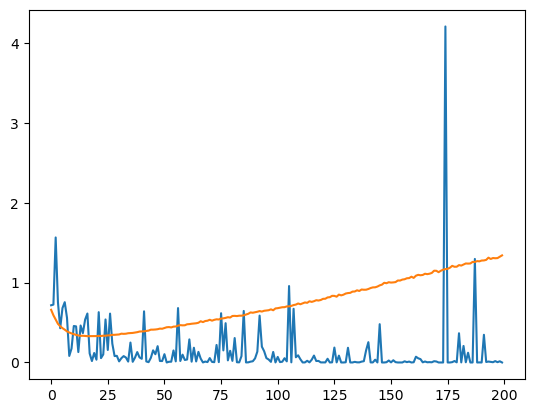

In [125]:
plt.plot(loss_train)
plt.plot(loss_validation)

### 200-128-64-16-4: better but still overfits

In [127]:
class SLDNN(nn.Module):
    def __init__(self):
        super(SLDNN, self).__init__()
        self.fc1 = nn.Linear(200, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 16)
        self.output = nn.Linear(16, 4)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        
        # CrossEntropyLoss apply softmax automatically
        return self.output(x)
    
#         x = self.sig(self.fc3(x))
#         return x

In [128]:
classifier = SLDNN().cuda()

print(sum(p.numel() for p in classifier.parameters() if p.requires_grad))

optimizer = optim.Adam(classifier.parameters(), lr=0.00005)
loss_func = nn.CrossEntropyLoss().cuda()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    classifier.train()
    for batchidx, (x, tgt_index) in enumerate(trainDataLoader):
        x = x.cuda()
        tgt_index = tgt_index.cuda()
        output = classifier(x)
        loss = loss_func(output, tgt_index)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, (x, tgt_index) in enumerate(validationDataLoader):
            x = x.cuda()
            tgt_index = tgt_index.cuda()
            output = classifier(x)
            lossVal = loss_func(output, tgt_index)
            val_loss += lossVal.item()
            n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f, valid accuracy=%f' % (epoch+1, loss_train[epoch], val_loss, n_correct*1./len(X_valid)))
    print(time.time() - t0)

#     print(time.time() - t0)
torch.save(classifier.cuda(), "../data/SupLearn/Classifier.pt")
np.savetxt("../data/SupLearn/lossClassifierTraining.dat", [loss_train, loss_validation])

35092
Epoch: 0001, Training loss=0.395813, Validation loss=0.718931, valid accuracy=0.682817
21.692484617233276
Epoch: 0002, Training loss=0.712611, Validation loss=0.648337, valid accuracy=0.726235
21.730019569396973
Epoch: 0003, Training loss=0.354911, Validation loss=0.601300, valid accuracy=0.751847
20.64396905899048
Epoch: 0004, Training loss=0.942349, Validation loss=0.558352, valid accuracy=0.766943
19.985103845596313
Epoch: 0005, Training loss=0.688014, Validation loss=0.514905, valid accuracy=0.787329
20.99190378189087
Epoch: 0006, Training loss=0.159022, Validation loss=0.488268, valid accuracy=0.798974
25.618062734603882
Epoch: 0007, Training loss=0.238200, Validation loss=0.473634, valid accuracy=0.804587
23.176112413406372
Epoch: 0008, Training loss=0.627101, Validation loss=0.463786, valid accuracy=0.810135
20.043574571609497
Epoch: 0009, Training loss=0.098818, Validation loss=0.453601, valid accuracy=0.815329
19.42044949531555
Epoch: 0010, Training loss=0.667101, Valida

Epoch: 0079, Training loss=0.076727, Validation loss=0.342375, valid accuracy=0.889649
23.556243181228638
Epoch: 0080, Training loss=0.040766, Validation loss=0.338582, valid accuracy=0.890487
21.225228786468506
Epoch: 0081, Training loss=0.007333, Validation loss=0.339197, valid accuracy=0.890326
20.81974196434021
Epoch: 0082, Training loss=0.117956, Validation loss=0.339865, valid accuracy=0.890165
20.362417221069336
Epoch: 0083, Training loss=0.037585, Validation loss=0.341204, valid accuracy=0.889971
19.284769773483276
Epoch: 0084, Training loss=0.024398, Validation loss=0.343531, valid accuracy=0.889681
19.03306531906128
Epoch: 0085, Training loss=0.035631, Validation loss=0.345502, valid accuracy=0.888391
19.77520251274109
Epoch: 0086, Training loss=0.019621, Validation loss=0.344446, valid accuracy=0.889004
21.71977996826172
Epoch: 0087, Training loss=0.009918, Validation loss=0.343408, valid accuracy=0.890842
22.010249137878418
Epoch: 0088, Training loss=0.013638, Validation lo

Epoch: 0157, Training loss=0.252284, Validation loss=0.420361, valid accuracy=0.886423
20.664656400680542
Epoch: 0158, Training loss=0.037169, Validation loss=0.428186, valid accuracy=0.886778
19.304491996765137
Epoch: 0159, Training loss=0.001286, Validation loss=0.426133, valid accuracy=0.887681
19.425873517990112
Epoch: 0160, Training loss=0.081131, Validation loss=0.422113, valid accuracy=0.889262
19.96852207183838
Epoch: 0161, Training loss=0.660350, Validation loss=0.422827, valid accuracy=0.887907
21.69620156288147
Epoch: 0162, Training loss=0.064863, Validation loss=0.424112, valid accuracy=0.888229
21.715214014053345
Epoch: 0163, Training loss=0.004870, Validation loss=0.426376, valid accuracy=0.888875
22.68890380859375
Epoch: 0164, Training loss=0.132991, Validation loss=0.430879, valid accuracy=0.888810
20.898095846176147
Epoch: 0165, Training loss=0.059999, Validation loss=0.428382, valid accuracy=0.888036
21.89225435256958
Epoch: 0166, Training loss=0.003319, Validation lo

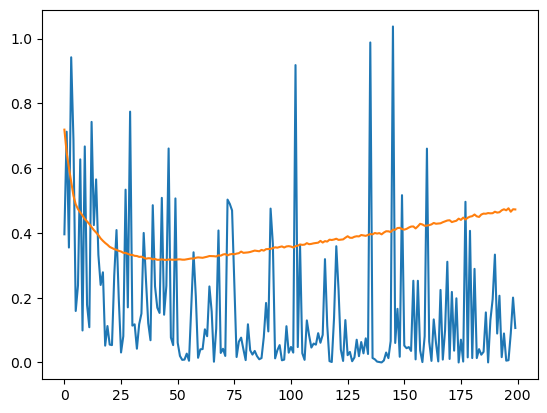

In [129]:
plt.plot(loss_train)
plt.plot(loss_validation)

### 200-64-16-4

In [18]:
class SLDNN(nn.Module):
    def __init__(self):
        super(SLDNN, self).__init__()
        self.fc1 = nn.Linear(200, 64)
        self.fc2 = nn.Linear(64, 16)
#         self.fc3 = nn.Linear(64, 16)
        self.output = nn.Linear(16, 4)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
#         x = self.act(self.fc3(x))
        
        # CrossEntropyLoss apply softmax automatically
        return self.output(x)
    
#         x = self.sig(self.fc3(x))
#         return x

In [131]:
classifier = SLDNN().cuda()

print(sum(p.numel() for p in classifier.parameters() if p.requires_grad))

optimizer = optim.Adam(classifier.parameters(), lr=0.00005)
loss_func = nn.CrossEntropyLoss().cuda()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    classifier.train()
    for batchidx, (x, tgt_index) in enumerate(trainDataLoader):
        x = x.cuda()
        tgt_index = tgt_index.cuda()
        output = classifier(x)
        loss = loss_func(output, tgt_index)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, (x, tgt_index) in enumerate(validationDataLoader):
            x = x.cuda()
            tgt_index = tgt_index.cuda()
            output = classifier(x)
            lossVal = loss_func(output, tgt_index)
            val_loss += lossVal.item()
            n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f, valid accuracy=%f' % (epoch+1, loss_train[epoch], val_loss, n_correct*1./len(X_valid)))
    print(time.time() - t0)

#     print(time.time() - t0)
torch.save(classifier.cuda(), "../data/SupLearn/Classifier.pt")
np.savetxt("../data/SupLearn/lossClassifierTraining.dat", [loss_train, loss_validation])

13972
Epoch: 0001, Training loss=1.456019, Validation loss=0.786205, valid accuracy=0.644721
18.16793918609619
Epoch: 0002, Training loss=0.650406, Validation loss=0.697365, valid accuracy=0.692591
21.656566619873047
Epoch: 0003, Training loss=0.233004, Validation loss=0.660391, valid accuracy=0.713590
20.478137016296387
Epoch: 0004, Training loss=0.493061, Validation loss=0.630474, valid accuracy=0.730622
22.07361149787903
Epoch: 0005, Training loss=0.812376, Validation loss=0.604382, valid accuracy=0.745363
20.356573343276978
Epoch: 0006, Training loss=0.136681, Validation loss=0.580074, valid accuracy=0.756556
20.248222827911377
Epoch: 0007, Training loss=1.263927, Validation loss=0.559727, valid accuracy=0.765620
20.941830158233643
Epoch: 0008, Training loss=0.834122, Validation loss=0.543950, valid accuracy=0.772265
22.41158962249756
Epoch: 0009, Training loss=0.511720, Validation loss=0.530675, valid accuracy=0.778265
20.44349694252014
Epoch: 0010, Training loss=0.186668, Validat

Epoch: 0079, Training loss=0.224497, Validation loss=0.363728, valid accuracy=0.863746
16.10002040863037
Epoch: 0080, Training loss=0.065723, Validation loss=0.362693, valid accuracy=0.864037
16.760319709777832
Epoch: 0081, Training loss=0.448424, Validation loss=0.364208, valid accuracy=0.863972
17.106816053390503
Epoch: 0082, Training loss=0.097563, Validation loss=0.362436, valid accuracy=0.863392
16.867675304412842
Epoch: 0083, Training loss=0.445731, Validation loss=0.362827, valid accuracy=0.864972
16.865190267562866
Epoch: 0084, Training loss=0.184864, Validation loss=0.362599, valid accuracy=0.864069
16.08500361442566
Epoch: 0085, Training loss=0.582457, Validation loss=0.362102, valid accuracy=0.864875
15.913988828659058
Epoch: 0086, Training loss=0.880240, Validation loss=0.361130, valid accuracy=0.864617
16.31640362739563
Epoch: 0087, Training loss=0.145845, Validation loss=0.361404, valid accuracy=0.865101
15.919841051101685
Epoch: 0088, Training loss=0.423221, Validation l

Epoch: 0157, Training loss=0.164304, Validation loss=0.352104, valid accuracy=0.870424
15.954104661941528
Epoch: 0158, Training loss=0.248748, Validation loss=0.351763, valid accuracy=0.871069
16.44610047340393
Epoch: 0159, Training loss=0.100241, Validation loss=0.351892, valid accuracy=0.871520
15.574841976165771
Epoch: 0160, Training loss=0.281585, Validation loss=0.352343, valid accuracy=0.870230
15.799652338027954
Epoch: 0161, Training loss=0.142405, Validation loss=0.351529, valid accuracy=0.871230
18.43275260925293
Epoch: 0162, Training loss=0.196535, Validation loss=0.352548, valid accuracy=0.870972
17.736987590789795
Epoch: 0163, Training loss=0.114269, Validation loss=0.351590, valid accuracy=0.871133
16.51880145072937
Epoch: 0164, Training loss=0.040650, Validation loss=0.351520, valid accuracy=0.870036
15.887745141983032
Epoch: 0165, Training loss=0.285730, Validation loss=0.352213, valid accuracy=0.869456
16.29120397567749
Epoch: 0166, Training loss=0.505116, Validation lo

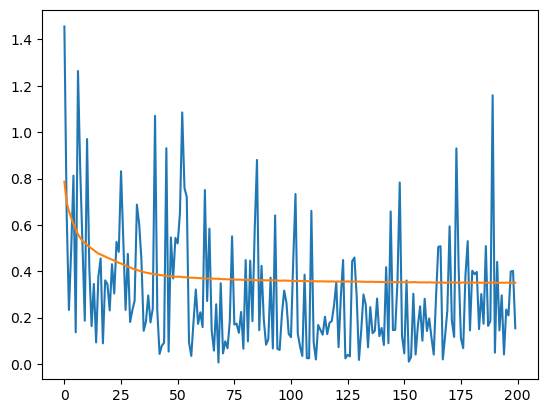

In [132]:
plt.plot(loss_train)
plt.plot(loss_validation)

In [133]:
classifier.cpu()

SLDNN(
  (fc1): Linear(in_features=200, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=4, bias=True)
  (act): ReLU()
)

In [137]:
X_train.shape

(216998, 200)

In [23]:
classifier = torch.load('../Model_cached/Classifier_64-16.pt').cpu()

In [24]:
outputTest = classifier(torch.FloatTensor(X_test))

In [25]:
resTest = torch.argmax(nn.Softmax(dim=1)(outputTest), dim=1)

In [26]:
resTest

tensor([1, 1, 1,  ..., 0, 1, 0])

In [27]:
target_test

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [28]:
print(torch.eq(torch.tensor(target_test), resTest).sum().item())
print(torch.eq(torch.tensor(target_test), resTest).sum().item() / len(target_test))

64311
0.8928859023130536


In [29]:
print(len(target_test) - torch.eq(torch.tensor(target_test>1), resTest<=1).sum().item())
print(1 - torch.eq(torch.tensor(target_test>1), resTest<=1).sum().item() / len(target_test))

65829
0.9139616249687613


#### BBH accuracy

#### SG accuracy

#### Noise accuracy

### 200-64-64-16-4

In [169]:
class SLDNN(nn.Module):
    def __init__(self):
        super(SLDNN, self).__init__()
        self.fc1 = nn.Linear(200, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 16)
        self.output = nn.Linear(16, 4)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        
        # CrossEntropyLoss apply softmax automatically
        return self.output(x)
    
#         x = self.sig(self.fc3(x))
#         return x

In [171]:
classifier = SLDNN().cuda()

print(sum(p.numel() for p in classifier.parameters() if p.requires_grad))

optimizer = optim.Adam(classifier.parameters(), lr=0.00005)
loss_func = nn.CrossEntropyLoss().cuda()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    classifier.train()
    for batchidx, (x, tgt_index) in enumerate(trainDataLoader):
        x = x.cuda()
        tgt_index = tgt_index.cuda()
        output = classifier(x)
        loss = loss_func(output, tgt_index)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, (x, tgt_index) in enumerate(validationDataLoader):
            x = x.cuda()
            tgt_index = tgt_index.cuda()
            output = classifier(x)
            lossVal = loss_func(output, tgt_index)
            val_loss += lossVal.item()
            n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f, valid accuracy=%f' % (epoch+1, loss_train[epoch], val_loss, n_correct*1./len(X_valid)))
    print(time.time() - t0)

#     print(time.time() - t0)
torch.save(classifier.cuda(), "../data/SupLearn/Classifier_64-64-16.pt")
np.savetxt("../data/SupLearn/lossClassifierTraining_64-64-16.dat", [loss_train, loss_validation])

18132
Epoch: 0001, Training loss=0.474716, Validation loss=0.742357, valid accuracy=0.666301
19.324056386947632
Epoch: 0002, Training loss=0.374694, Validation loss=0.680511, valid accuracy=0.710719
18.770312786102295
Epoch: 0003, Training loss=0.670147, Validation loss=0.638941, valid accuracy=0.732686
26.299160957336426
Epoch: 0004, Training loss=1.250036, Validation loss=0.613479, valid accuracy=0.747782
25.375213623046875
Epoch: 0005, Training loss=0.738831, Validation loss=0.598099, valid accuracy=0.755072
24.368035554885864
Epoch: 0006, Training loss=0.144531, Validation loss=0.584319, valid accuracy=0.763653
26.16805338859558
Epoch: 0007, Training loss=0.956067, Validation loss=0.573101, valid accuracy=0.768459
22.840923309326172
Epoch: 0008, Training loss=0.247889, Validation loss=0.559672, valid accuracy=0.771911
17.952731370925903
Epoch: 0009, Training loss=0.985831, Validation loss=0.545236, valid accuracy=0.777846
19.1991286277771
Epoch: 0010, Training loss=0.119106, Valida

Epoch: 0079, Training loss=0.413522, Validation loss=0.343796, valid accuracy=0.872682
22.00032067298889
Epoch: 0080, Training loss=0.232846, Validation loss=0.341762, valid accuracy=0.872649
21.60247564315796
Epoch: 0081, Training loss=0.185144, Validation loss=0.341279, valid accuracy=0.871746
20.81746816635132
Epoch: 0082, Training loss=0.694943, Validation loss=0.340446, valid accuracy=0.873165
15.635480403900146
Epoch: 0083, Training loss=0.013741, Validation loss=0.339733, valid accuracy=0.873811
18.37843155860901
Epoch: 0084, Training loss=0.176204, Validation loss=0.340330, valid accuracy=0.873552
18.112579584121704
Epoch: 0085, Training loss=0.044700, Validation loss=0.338964, valid accuracy=0.874036
18.610584497451782
Epoch: 0086, Training loss=0.085692, Validation loss=0.338031, valid accuracy=0.873004
17.6256582736969
Epoch: 0087, Training loss=1.271693, Validation loss=0.336898, valid accuracy=0.874456
17.54631781578064
Epoch: 0088, Training loss=0.262004, Validation loss=

Epoch: 0157, Training loss=0.030162, Validation loss=0.323473, valid accuracy=0.883068
16.576465368270874
Epoch: 0158, Training loss=0.017756, Validation loss=0.323684, valid accuracy=0.882520
17.201162338256836
Epoch: 0159, Training loss=0.049744, Validation loss=0.322051, valid accuracy=0.882294
16.998027324676514
Epoch: 0160, Training loss=0.020710, Validation loss=0.324497, valid accuracy=0.882488
18.030097723007202
Epoch: 0161, Training loss=0.132886, Validation loss=0.323545, valid accuracy=0.883584
17.672110080718994
Epoch: 0162, Training loss=0.104540, Validation loss=0.323433, valid accuracy=0.882488
18.239886045455933
Epoch: 0163, Training loss=0.748655, Validation loss=0.322065, valid accuracy=0.883455
22.136264085769653
Epoch: 0164, Training loss=0.167221, Validation loss=0.323359, valid accuracy=0.883875
22.291666269302368
Epoch: 0165, Training loss=0.276267, Validation loss=0.322165, valid accuracy=0.883036
21.337865114212036
Epoch: 0166, Training loss=0.061257, Validatio

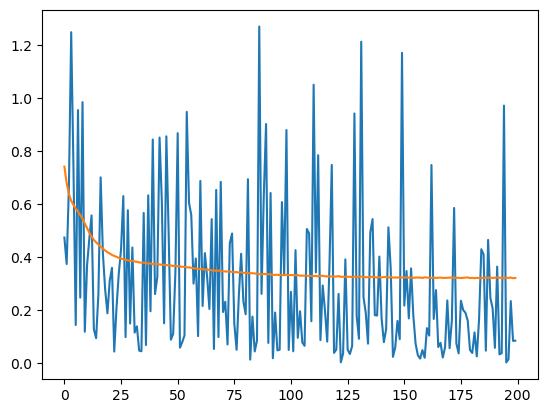

In [172]:
plt.plot(loss_train)
plt.plot(loss_validation)

In [173]:
classifier.eval()
classifier.cpu()

SLDNN(
  (fc1): Linear(in_features=200, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=4, bias=True)
  (act): ReLU()
)

In [25]:
outputTest = nn.Softmax(dim=1)(classifier(torch.FloatTensor(X_test)))

In [26]:
resTest = torch.argmax(outputTest, dim=1)

In [178]:
print(torch.eq(torch.tensor(target_test), resTest).sum().item())
print(torch.eq(torch.tensor(target_test), resTest).sum().item() / len(target_test))

54902
0.8855304117808351


In [179]:
print(len(target_test) - torch.eq(torch.tensor(target_test>1), resTest<=1).sum().item())
print(1 - torch.eq(torch.tensor(target_test>1), resTest<=1).sum().item() / len(target_test))

55661
0.8977725447184632


In [184]:
foo = outputTest.detach().numpy()

In [202]:
def calcROCPoint(index, threshold):
    nTotalSignal = np.sum(target_test==index)
    nTotalBKG = len(target_test) - nTotalSignal;
    
    nTP = np.sum(np.logical_and(target_test==index, foo[:, index]>threshold));
#     nFN = nTotalSignal - nTP;
    nFP = np.sum(np.logical_and(target_test!=index, foo[:, index]>threshold));
#     nTN = nTotalBKG - nFP;
    
    return [nFP/nTotalBKG, nTP/nTotalSignal]

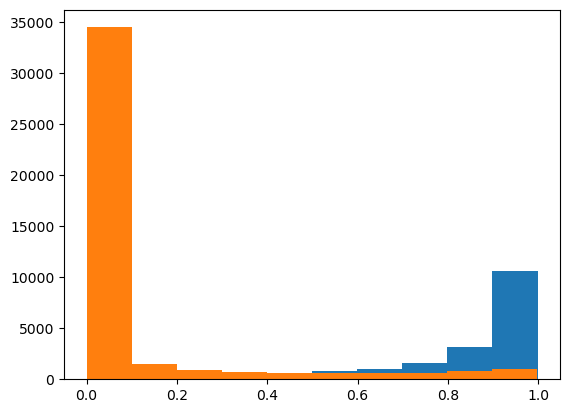

In [200]:
bar = plt.hist(foo[target_test==1, 1])
bar = plt.hist(foo[target_test!=1, 1])

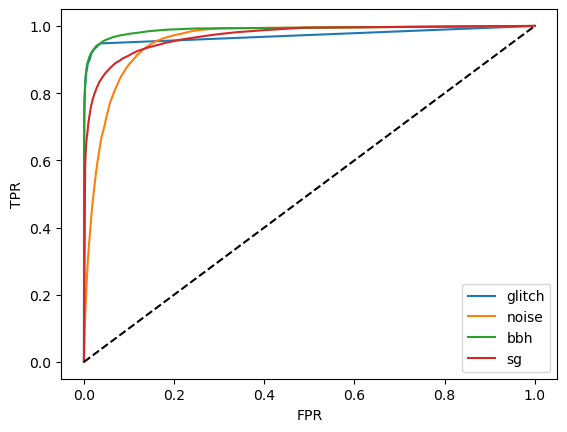

In [216]:
sig_type = ["glitch", "noise", "bbh", "sg"]
for ind in range(4):
    bar = np.array([calcROCPoint(ind, 1-0.01*i) for i in range(101)])
    plt.plot(bar[:, 0], bar[:, 1], label=sig_type[ind])
    
plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.savefig("../results/SupLearnROC_64-64-16.jpg")

### 200-64-16-3

In [16]:
class SLDNN(nn.Module):
    def __init__(self):
        super(SLDNN, self).__init__()
        self.fc1 = nn.Linear(200, 32)
        self.fc2 = nn.Linear(32, 8)
#         self.fc3 = nn.Linear(64, 16)
        self.output = nn.Linear(8, 3)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
#         x = self.act(self.fc3(x))
        
        # CrossEntropyLoss apply softmax automatically
        return self.output(x)
    
#         x = self.sig(self.fc3(x))
#         return x

In [120]:
class SLDNN(nn.Module):
    def __init__(self):
        super(SLDNN, self).__init__()
        self.fc1 = nn.Linear(200, 64)
        self.fc2 = nn.Linear(64, 16)
#         self.fc3 = nn.Linear(64, 16)
        self.output = nn.Linear(16, 3)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
#         x = self.act(self.fc3(x))
        
        # CrossEntropyLoss apply softmax automatically
        return self.output(x)
    
#         x = self.sig(self.fc3(x))
#         return x

In [176]:
class SLDNN(nn.Module):
    def __init__(self):
        super(SLDNN, self).__init__()
        self.fc1 = nn.Linear(101, 32)
        self.fc2 = nn.Linear(32, 8)
#         self.fc3 = nn.Linear(64, 16)
        self.output = nn.Linear(8, 3)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
#         x = self.act(self.fc3(x))
        
        # CrossEntropyLoss apply softmax automatically
        return self.output(x)
    
#         x = self.sig(self.fc3(x))
#         return x

In [27]:
torch.clamp(torch.tensor([1]), min=1e-8) 

tensor([1.])

In [121]:
def custom_cross_entropy_loss(input, target):
    """
    自定义的交叉熵损失函数
    
    参数:
    input (torch.Tensor): 模型输出的logits,shape为 (batch_size, num_classes)
    target (torch.Tensor): 真实标签,shape为 (batch_size,)
    """
    batch_size = input.size(0)
    # print(batch_size)
    
    # 使用 sigmoid 计算概率
    prob = torch.sigmoid(input)
    prob = torch.clamp(prob, 1e-5, 1-1e-5)
    # print(prob)
    
    # 计算 log(1-p) 部分
    loss_pos = -torch.log(prob.gather(1, target.unsqueeze(1))).squeeze(1)
    # print(loss_pos)

    # 获取非目标位置的索引
    non_target_idx = torch.ones_like(input, dtype=torch.bool)
    # print(non_target_idx)
    non_target_idx.scatter_(1, target.unsqueeze(1), 0)
    # print(non_target_idx)

    # 计算非目标位置的 log 损失
    # print(prob.masked_select(non_target_idx))
    loss_neg = -torch.log(1 - prob).masked_select(non_target_idx)
    # print(loss_neg)
    
    # 计算平均损失
    loss = (loss_pos.sum() + loss_neg.sum()) / batch_size
    
    return loss

In [409]:
wenhao = torch.tensor(1e10)
wenhao = torch.clamp(wenhao, 1e-8, 1e5)
wenhao

tensor(100000.)

In [418]:
torch.log(torch.Tensor([1e+300]))

tensor([inf])

In [383]:
output.shape

torch.Size([32, 3])

In [384]:
test = torch.tensor(np.array([[1,2,3],[4,5,6]]))

In [385]:
test

tensor([[1, 2, 3],
        [4, 5, 6]], dtype=torch.int32)

In [386]:
target = torch.tensor([0,1])

In [387]:
target

tensor([0, 1])

In [396]:
wenhao = custom_cross_entropy_loss(test, target)

2
tensor([[0.7311, 0.8808, 0.9526],
        [0.9820, 0.9933, 0.9975]])
tensor([0.3133, 0.0067])
tensor([[True, True, True],
        [True, True, True]])
tensor([[False,  True,  True],
        [ True, False,  True]])
tensor([0.8808, 0.9526, 0.9820, 0.9975])
tensor([2.1269, 3.0486, 4.0181, 6.0025])


In [397]:
wenhao

tensor(7.7581)

In [76]:
test_sigmoided = torch.sigmoid(test)

In [77]:
test_sigmoided

tensor([[0.7311, 0.8808, 0.9526]])

In [78]:
1-test_sigmoided

tensor([[0.2689, 0.1192, 0.0474]])

In [94]:
target = torch.tensor([0])

In [95]:
target.unsqueeze(1).shape

torch.Size([1, 1])

In [96]:
test_sigmoided

tensor([[0.7311, 0.8808, 0.9526]])

In [98]:
test_sigmoided.gather(1,target.unsqueeze(1)).squeeze(1)

tensor([0.7311])

In [99]:
non_target_idx = torch.arange(target.size(1)).unsqueeze(0).expand(target.size(0), -1)
non_target_idx = non_target_idx[~target.unsqueeze(1).bool()]

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [402]:
X_train.shape
target_train.max()

2

In [29]:
classifier = SLDNN()

print(sum(p.numel() for p in classifier.parameters() if p.requires_grad))

optimizer = optim.Adam(classifier.parameters(), lr=0.00005)
loss_func = nn.CrossEntropyLoss()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    classifier.train()
    for batchidx, (x, tgt_index) in enumerate(trainDataLoader):
        x = x
        tgt_index = tgt_index
        output = classifier(x)
        loss = custom_cross_entropy_loss(output, tgt_index)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, (x, tgt_index) in enumerate(validationDataLoader):
            x = x
            tgt_index = tgt_index
            output = classifier(x)
            lossVal = custom_cross_entropy_loss(output, tgt_index)
            val_loss += lossVal.item()
            n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f, valid accuracy=%f' % (epoch+1, loss_train[epoch], val_loss, n_correct*1./len(X_valid)))
    print(time.time() - t0)

#     print(time.time() - t0)


3555


Epoch: 0001, Training loss=1.195268, Validation loss=1.261949, valid accuracy=0.888368
10.80353593826294
Epoch: 0002, Training loss=0.525606, Validation loss=0.599485, valid accuracy=0.931537
10.82542109489441
Epoch: 0003, Training loss=0.116243, Validation loss=0.386162, valid accuracy=0.939571
10.641057968139648
Epoch: 0004, Training loss=0.490595, Validation loss=0.340940, valid accuracy=0.940763
10.664426565170288
Epoch: 0005, Training loss=0.541629, Validation loss=0.323967, valid accuracy=0.941570
10.778106451034546
Epoch: 0006, Training loss=0.582736, Validation loss=0.314313, valid accuracy=0.942685
10.671634197235107
Epoch: 0007, Training loss=0.212081, Validation loss=0.307277, valid accuracy=0.944261
10.689535140991211
Epoch: 0008, Training loss=0.165098, Validation loss=0.301849, valid accuracy=0.944299
10.752663850784302
Epoch: 0009, Training loss=0.427276, Validation loss=0.297589, valid accuracy=0.944953
10.672666788101196
Epoch: 0010, Training loss=0.111464, Validation 

In [123]:
classifier = SLDNN().cuda()

print(sum(p.numel() for p in classifier.parameters() if p.requires_grad))

optimizer = optim.Adam(classifier.parameters(), lr=0.00005, weight_decay=0.01)
loss_func = nn.CrossEntropyLoss().cuda()
loss_train = np.empty((epochs, ))
loss_validation = np.empty((epochs, ))

for epoch in range(epochs):

    t0 = time.time()
    classifier.train()
    for batchidx, (x, tgt_index) in enumerate(trainDataLoader):
        x = x.cuda()
        tgt_index = tgt_index.cuda()
        output = classifier(x)
        loss = loss_func(output, tgt_index)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    classifier.eval()
    with torch.no_grad():
        val_loss = 0
        n_correct = 0;
        for batchidx, (x, tgt_index) in enumerate(validationDataLoader):
            x = x.cuda()
            tgt_index = tgt_index.cuda()
            output = classifier(x)
            lossVal = loss_func(output, tgt_index)
            val_loss += lossVal.item()
            n_correct += torch.eq(tgt_index, torch.argmax(output, dim=1)).sum().item()

        val_loss /= len(validationDataLoader)

    loss_train[epoch] = loss.item()
    loss_validation[epoch] = val_loss
    print('Epoch: %04d, Training loss=%f, Validation loss=%f, valid accuracy=%f' % (epoch+1, loss_train[epoch], val_loss, n_correct*1./len(X_valid)))
    print(time.time() - t0)

#     print(time.time() - t0)


13955
Epoch: 0001, Training loss=0.321709, Validation loss=0.416574, valid accuracy=0.858269
10.580481052398682
Epoch: 0002, Training loss=0.377859, Validation loss=0.298013, valid accuracy=0.898747
10.581475734710693
Epoch: 0003, Training loss=0.479324, Validation loss=0.247875, valid accuracy=0.917890
10.644080638885498
Epoch: 0004, Training loss=0.088642, Validation loss=0.227563, valid accuracy=0.924464
10.646225929260254
Epoch: 0005, Training loss=0.116012, Validation loss=0.217027, valid accuracy=0.927731
10.578924894332886
Epoch: 0006, Training loss=0.110546, Validation loss=0.210997, valid accuracy=0.930999
10.511455535888672
Epoch: 0007, Training loss=0.117816, Validation loss=0.205682, valid accuracy=0.933074
10.581835985183716
Epoch: 0008, Training loss=0.438607, Validation loss=0.202248, valid accuracy=0.934151
10.64873218536377
Epoch: 0009, Training loss=0.199031, Validation loss=0.198778, valid accuracy=0.936150
10.535971641540527
Epoch: 0010, Training loss=0.461471, Vali

In [124]:
torch.save(classifier.cpu(), "../Data_cached/SupLearn/Classifier_multisigmoid_weight_decay.pt")
np.savetxt("../Data_cached/SupLearn/lossClassifierTraining_multisigmoid_weight_decay.dat", [loss_train, loss_validation])

In [ ]:
classifier = torch.load()

In [179]:
classifier = torch.load("../Data_cached/SupLearn/Classifier_multisigmoid_fft.pt").cpu()

In [17]:
classifier = torch.load("../Data_cached/SupLearn/Classifier_reduced.pt").cpu()

In [180]:
classifier

SLDNN(
  (fc1): Linear(in_features=101, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=3, bias=True)
  (act): ReLU()
)

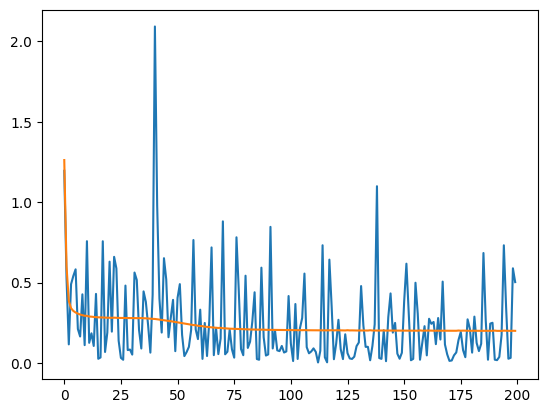

In [30]:
plt.plot(loss_train)
plt.plot(loss_validation)

In [15]:
classifier.cpu()

SLDNN(
  (fc1): Linear(in_features=200, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=3, bias=True)
  (act): ReLU()
)

In [26]:
X_train.shape

(182092, 200)

In [16]:
X_test.shape

(72026, 200)

In [29]:
3 * nTest

60000

In [30]:
nTest_g

12026

In [182]:
testData = torch.FloatTensor(X_test)

In [189]:
outputTest = classifier(testData)
resTest_beforeSM = nn.Sigmoid()(outputTest).detach().numpy()
resTest = torch.argmax(nn.Sigmoid()(outputTest), dim=1)

In [20]:
outputTest = classifier(testData)
resTest_beforeSM = nn.Softmax(dim = 1)(outputTest).detach().numpy()
resTest = torch.argmax(nn.Softmax(dim = 1)(outputTest), dim=1)

In [224]:
nn.Softmax()(classifier(testData[1]))

C:\Users\Liyang Miao\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([3.9118e-05, 9.9958e-01, 3.7686e-04], grad_fn=<SoftmaxBackward0>)

In [32]:
# X_test[:nTest] = realbkg_trimmed[permBKG[-nTest:]]
# X_test[nTest:2*nTest] = realbbh_trimmed[permBBH[-nTest:]]
# X_test[2*nTest:3*nTest] = realsg_trimmed[permSG[-nTest:]]
# X_test[3*nTest:] = realglitch_trimmed[permGLITCH[-nTest_g:]]

# target_test[:nTest] = 1;
# target_test[nTest:2*nTest] = 2;
# target_test[2*nTest:3*nTest] = 3;


resTest = nn.Sigmoid()(classifier(torch.FloatTensor(X_test)))

In [225]:
resTest = torch.argmax(nn.Softmax(dim=1)(outputTest), dim=1)

In [226]:
resTest[1]

tensor(1)

In [160]:
Sigmoid_cut_glitch = np.arange(0.8,1.001,0.02)
Sigmoid_cut_noise = np.arange(0.9,1.001,0.001)
Sigmoid_cut_bbh = np.arange(0.8,1.001,0.02)

In [161]:
import itertools

Sigmoid_cut = np.array(list(itertools.product(Sigmoid_cut_glitch, Sigmoid_cut_noise, Sigmoid_cut_bbh)))

In [55]:
Sigmoid_cut[-1]

array([0.9 , 0.98, 0.9 ])

In [231]:
Sigmoid_cut[-1][0] == 0.35

False

In [232]:
target_test

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [233]:
nn.Sigmoid()(classifier(testData[0])) < Sigmoid_cut[0]

TypeError: '<' not supported between instances of 'Tensor' and 'numpy.ndarray'

In [54]:
np.all(nn.Sigmoid()(classifier(testData[0])).detach().numpy() < Sigmoid_cut[0])

False

In [23]:
np.all(nn.Softmax()(classifier(testData)).detach().numpy() < Sigmoid_cut[1], axis = 1).shape

C:\Users\Liyang Miao\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


(72026,)

In [37]:
np.sum(nn.Sigmoid()(outputTest).detach().numpy(), axis = 1)

array([1.0070342 , 0.9995074 , 0.9993094 , ..., 1.0043541 , 1.0033128 ,
       0.99921304], dtype=float32)

In [154]:
resTest = torch.argmax(nn.Softmax()(outputTest), dim=1)

C:\Users\Liyang Miao\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [155]:
(resTest[2*nTest:3*nTest].detach().numpy() == 3).sum()

0

In [190]:
accuracy_overall_beforehand = ((resTest[3*nTest:].detach().numpy() == 0).sum() + (resTest[:nTest].detach().numpy() == 1).sum() + (resTest[nTest:2*nTest].detach().numpy() == 2).sum() + 
                           (resTest[2*nTest:3*nTest].detach().numpy() == 3).sum()) / (3 * nTest + nTest_g)

In [191]:
accuracy_overall_beforehand

0.6937494793546775

In [192]:
accuracy_beforehand = np.array([(resTest[3*nTest:].detach().numpy() == 0).sum() / nTest_g,
    (resTest[:nTest].detach().numpy() == 1).sum() / nTest,
    (resTest[nTest:2*nTest].detach().numpy() == 2).sum() / nTest,
    (resTest[2*nTest:3*nTest].detach().numpy() == 3).sum() / nTest])

In [193]:
accuracy_beforehand

array([0.99501081, 0.9544    , 0.9457    , 0.        ])

In [187]:
accuracy = np.zeros((len(Sigmoid_cut), 4))
accuracy_overall = np.zeros((len(Sigmoid_cut)))

for i in range(len(Sigmoid_cut)):
    
    resTest = torch.argmax(nn.Sigmoid()(outputTest), dim=1)

    resTest[np.all(nn.Sigmoid()(outputTest).detach().numpy() <= Sigmoid_cut[i], axis = 1)] = 3
    
    accuracy_glitch = (resTest[3*nTest:].detach().numpy() == 0).sum() / nTest_g
    accuracy_noise = (resTest[:nTest].detach().numpy() == 1).sum() / nTest
    accuracy_bbh = (resTest[nTest:2*nTest].detach().numpy() == 2).sum() / nTest
    accuracy_sg = (resTest[2*nTest:3*nTest].detach().numpy() == 3).sum() / nTest

    accuracy[i] = np.array([accuracy_glitch, accuracy_noise, accuracy_bbh, accuracy_sg])
    accuracy_overall[i] = ((resTest[3*nTest:].detach().numpy() == 0).sum() + (resTest[:nTest].detach().numpy() == 1).sum() + (resTest[nTest:2*nTest].detach().numpy() == 2).sum() + 
                           (resTest[2*nTest:3*nTest].detach().numpy() == 3).sum()) / (3 * nTest + nTest_g)

In [166]:
accuracy = np.zeros((len(Sigmoid_cut), 4))
accuracy_overall = np.zeros((len(Sigmoid_cut)))

for i in range(len(Sigmoid_cut)):
    
    resTest = torch.argmax(nn.Softmax(dim = 1)(outputTest), dim=1)

    resTest[np.all(nn.Softmax(dim = 1)(outputTest).detach().numpy() <= Sigmoid_cut[i], axis = 1)] = 3
    
    accuracy_glitch = (resTest[3*nTest:].detach().numpy() == 0).sum() / nTest_g
    accuracy_noise = (resTest[:nTest].detach().numpy() == 1).sum() / nTest
    accuracy_bbh = (resTest[nTest:2*nTest].detach().numpy() == 2).sum() / nTest
    accuracy_sg = (resTest[2*nTest:3*nTest].detach().numpy() == 3).sum() / nTest

    accuracy[i] = np.array([accuracy_glitch, accuracy_noise, accuracy_bbh, accuracy_sg])
    accuracy_overall[i] = ((resTest[3*nTest:].detach().numpy() == 0).sum() + (resTest[:nTest].detach().numpy() == 1).sum() + (resTest[nTest:2*nTest].detach().numpy() == 2).sum() + 
                           (resTest[2*nTest:3*nTest].detach().numpy() == 3).sum()) / (3 * nTest + nTest_g)

In [165]:
Sigmoid_cut

array([[0.8 , 0.9 , 0.8 ],
       [0.8 , 0.9 , 0.82],
       [0.8 , 0.9 , 0.84],
       ...,
       [1.  , 1.  , 0.96],
       [1.  , 1.  , 0.98],
       [1.  , 1.  , 1.  ]])

In [152]:
accuracy[np.argwhere(np.logical_and(Sigmoid_cut[:,0] == 0.8, Sigmoid_cut[:,2] == 0.8))]

array([[[0.93106602, 0.8436    , 0.8663    , 0.08715   ]],

       [[0.93106602, 0.82975   , 0.8663    , 0.0942    ]],

       [[0.93106602, 0.81695   , 0.8663    , 0.1034    ]],

       [[0.93106602, 0.80025   , 0.8663    , 0.1142    ]],

       [[0.93106602, 0.7771    , 0.8663    , 0.12865   ]],

       [[0.93106602, 0.75165   , 0.8663    , 0.1461    ]],

       [[0.93106602, 0.7137    , 0.8663    , 0.16905   ]],

       [[0.93106602, 0.6652    , 0.8663    , 0.2062    ]],

       [[0.93106602, 0.58715   , 0.8663    , 0.267     ]],

       [[0.93106602, 0.43935   , 0.8663    , 0.38685   ]],

       [[0.93106602, 0.        , 0.8663    , 0.9382    ]]])

In [153]:
accuracy_overall[np.argwhere(np.logical_and(Sigmoid_cut[:,0] == 0.8, Sigmoid_cut[:,2] == 0.8))]

array([[0.65445811],
       [0.65256991],
       [0.65157027],
       [0.64993197],
       [0.64751617],
       [0.64529475],
       [0.64112959],
       [0.63797795],
       [0.63318802],
       [0.62542693],
       [0.65652681]])

In [167]:
accuracy_overall[np.argwhere(np.logical_and(Sigmoid_cut[:,0] == 0.8, Sigmoid_cut[:,2] == 0.8))]

array([[0.64529475],
       [0.64497543],
       [0.6448227 ],
       [0.64444784],
       [0.6442257 ],
       [0.64407297],
       [0.64383695],
       [0.6435315 ],
       [0.64326771],
       [0.64304557],
       [0.64283731],
       [0.6426707 ],
       [0.64237914],
       [0.64233749],
       [0.64219865],
       [0.64196262],
       [0.64183767],
       [0.64167106],
       [0.64146281],
       [0.6413795 ],
       [0.64112959],
       [0.6408658 ],
       [0.64075473],
       [0.64075473],
       [0.64058812],
       [0.64039375],
       [0.64007442],
       [0.63986616],
       [0.63979674],
       [0.63975509],
       [0.63971344],
       [0.63938022],
       [0.63901924],
       [0.63885264],
       [0.6387971 ],
       [0.63861661],
       [0.63875545],
       [0.63842224],
       [0.63829728],
       [0.63811679],
       [0.63797795],
       [0.63789465],
       [0.63751978],
       [0.63722822],
       [0.63700608],
       [0.63693666],
       [0.636298  ],
       [0.636

In [188]:
accuracy_overall[np.argwhere(np.logical_and(Sigmoid_cut[:,0] == 0.8, Sigmoid_cut[:,2] == 0.8))]

array([[0.71074334],
       [0.71088218],
       [0.7108683 ],
       [0.71115986],
       [0.71127093],
       [0.7114653 ],
       [0.71145142],
       [0.71161803],
       [0.71156249],
       [0.71157638],
       [0.71167356],
       [0.7117291 ],
       [0.71157638],
       [0.71159026],
       [0.71165968],
       [0.71163191],
       [0.71160414],
       [0.71156249],
       [0.71174298],
       [0.71190959],
       [0.71182628],
       [0.71204843],
       [0.71202066],
       [0.71217338],
       [0.71222892],
       [0.7121595 ],
       [0.71217338],
       [0.71246494],
       [0.71225669],
       [0.71227057],
       [0.71239552],
       [0.71222892],
       [0.71217338],
       [0.71221503],
       [0.71225669],
       [0.7122428 ],
       [0.71225669],
       [0.71229834],
       [0.71227057],
       [0.71225669],
       [0.71229834],
       [0.71242329],
       [0.71231222],
       [0.71277039],
       [0.71288146],
       [0.71292311],
       [0.71304807],
       [0.713

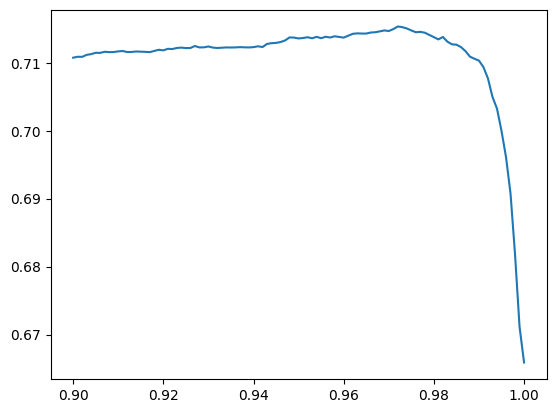

In [195]:
plt.plot(np.arange(0.9, 1.001, 0.001), accuracy_overall[np.argwhere(np.logical_and(Sigmoid_cut[:,0] == 0.8, Sigmoid_cut[:,2] == 0.8))])

In [132]:
accuracy.shape

(1000, 4)

In [49]:
accuracy[np.argwhere(np.logical_and(Sigmoid_cut[:,0] == 0.4, Sigmoid_cut[:,2] == 0.4))]

array([], shape=(0, 1, 4), dtype=float64)

In [50]:
accuracy

array([[0.99027108, 0.88245   , 0.8967    , 0.1717    ],
       [0.99027108, 0.88245   , 0.89085   , 0.17555   ],
       [0.99027108, 0.88245   , 0.88515   , 0.17935   ],
       ...,
       [0.97596873, 0.55615   , 0.82785   , 0.55975   ],
       [0.97596873, 0.55615   , 0.8       , 0.5688    ],
       [0.97596873, 0.55615   , 0.75485   , 0.57985   ]])

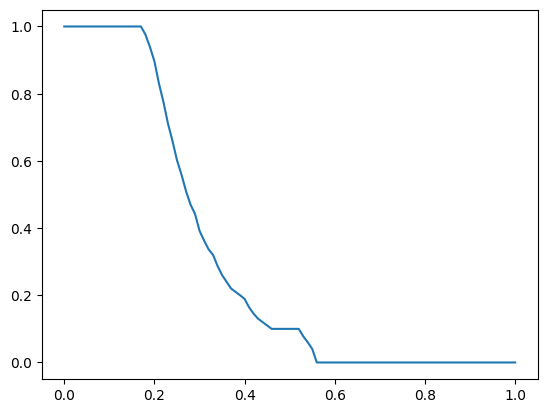

In [51]:
foo = np.array([ [0.01*A, np.sum(np.all(accuracy >= 0.01*A, axis=1))/len(accuracy)] for A in range(101)])
plt.plot(foo[:, 0], foo[:, 1])

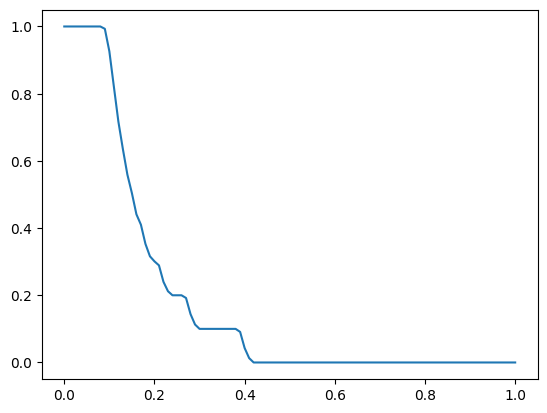

In [284]:
foo = np.array([ [0.01*A, np.sum(np.all(accuracy >= 0.01*A, axis=1))/len(accuracy)] for A in range(101)])
plt.plot(foo[:, 0], foo[:, 1])

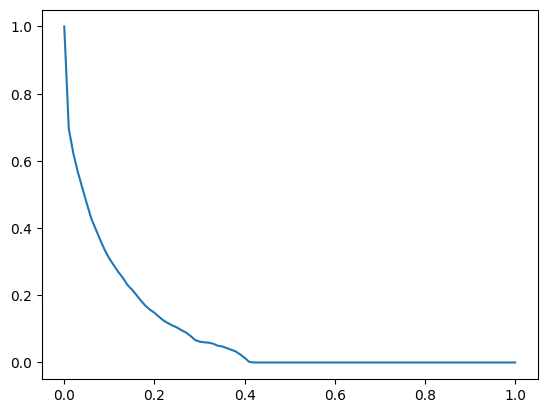

In [64]:
foo = np.array([ [0.01*A, np.sum(np.all(accuracy >= 0.01*A, axis=1))/len(accuracy)] for A in range(101)])
plt.plot(foo[:, 0], foo[:, 1])

In [127]:
ind2datatype = ['glitch','noise','bbh']

In [129]:
cutList = {
    'glitch':Sigmoid_cut_glitch,
    'noise':Sigmoid_cut_noise,
    'bbh':Sigmoid_cut_bbh
}

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(20, 15))
for i in range(len(list_datatype)):
    for j in range(i+1, len(list_datatype)):
        X, Y = np.meshgrid(cutList[ind2datatype[i]], cutList[ind2datatype[j]])
        Z = np.reshape([max([np.all(listResult["cut"][:, [i,j]]==cut, axis=1)]) for cut in np.array([X.flatten(), Y.flatten()]).T], (len(Y), len(X)))
        CS = ax[j-1, i].contour(X, Y, Z)

        ax[j-1,i].clabel(CS, inline=True, fontsize=10)
        ax[j-1,i].set_xlabel(ind2datatype[i]+" probalistic cut")
        ax[j-1,i].set_ylabel(ind2datatype[j]+" probalistic cut")

fig.suptitle("4-class accuracy", fontsize=30, y=0.92)
# plt.savefig("../results/contours_4-class.pdf")

In [206]:
Sigmoid_cut = np.array(Sigmoid_cut)

In [275]:
Sigmoid_cut[np.argwhere(np.logical_and(np.array(Sigmoid_cut)[:,0] == 0.1, np.array(Sigmoid_cut)[:,1] == 0.9)).astype(int)]

array([], shape=(0, 1, 3), dtype=float64)

In [204]:
np.argwhere(np.logical_and(np.array(Sigmoid_cut)[:,0] == other_cut, np.array(Sigmoid_cut)[:,2] == other_cut)).flatten()

array([505, 515, 525, 535, 545, 555, 565, 575, 585, 595], dtype=int64)

In [255]:
np.argwhere(np.logical_and(Sigmoid_cut[:,1] == 0.82, Sigmoid_cut[:,0] == 0.15)).astype(int).flatten()

array([], dtype=int32)

Text(0, 0.5, 'accuracy')

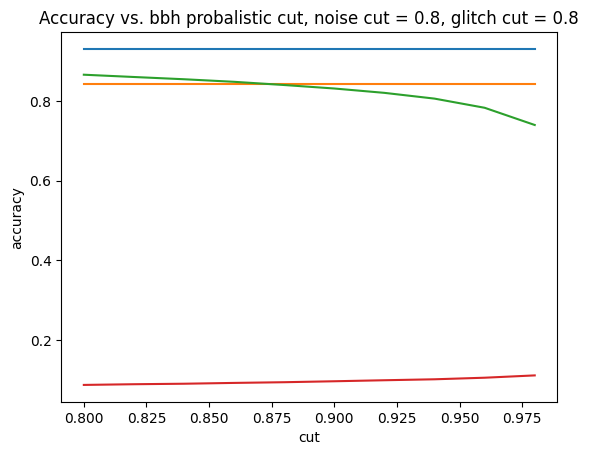

In [285]:
other_cut = 0.25

plt.plot(Sigmoid_cut_bbh, accuracy[np.argwhere(np.logical_and(Sigmoid_cut[:,1] == 0.8, Sigmoid_cut[:,0] == 0.8)).astype(int).flatten()])
plt.title('Accuracy vs. bbh probalistic cut, noise cut = 0.8, glitch cut = 0.8')
plt.xlabel('cut')
plt.ylabel('accuracy')

Text(0, 0.5, 'accuracy')

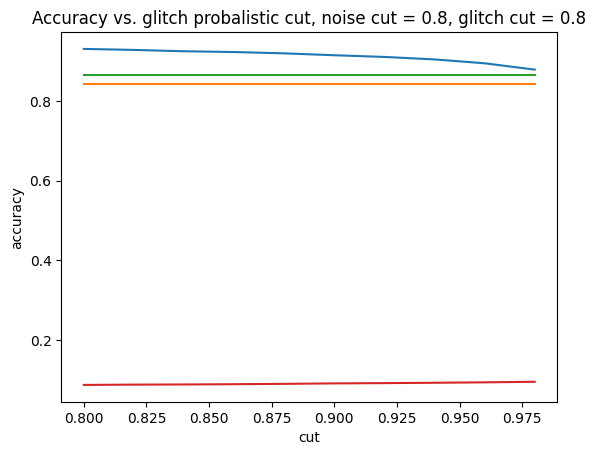

In [286]:
other_cut = 0.25

plt.plot(Sigmoid_cut_bbh, accuracy[np.argwhere(np.logical_and(Sigmoid_cut[:,1] == 0.8, Sigmoid_cut[:,2] == 0.8)).astype(int).flatten()])
plt.title('Accuracy vs. glitch probalistic cut, noise cut = 0.8, glitch cut = 0.8')
plt.xlabel('cut')
plt.ylabel('accuracy')

Text(0, 0.5, 'accuracy')

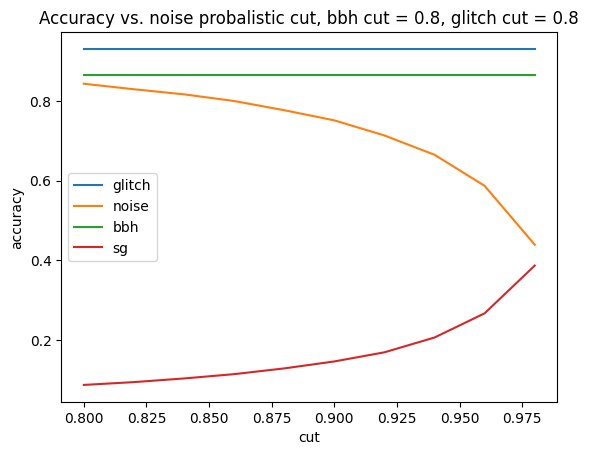

In [289]:
other_cut = 0.8

plt.plot(Sigmoid_cut_noise, accuracy[np.argwhere(np.logical_and(np.array(Sigmoid_cut)[:,0] == other_cut, np.array(Sigmoid_cut)[:,2] == other_cut)).astype(int).flatten()], label = ['glitch','noise','bbh','sg'])
plt.title('Accuracy vs. noise probalistic cut, bbh cut = 0.8, glitch cut = 0.8')
plt.legend()
plt.xlabel('cut')
plt.ylabel('accuracy')

Text(0, 0.5, 'accuracy')

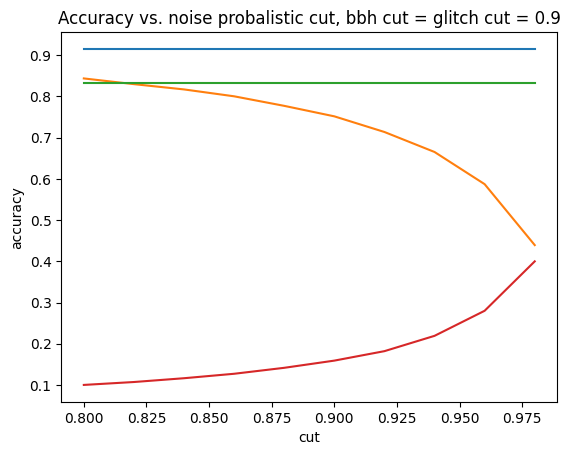

In [264]:
other_cut = 0.9

plt.plot(Sigmoid_cut_noise, accuracy[np.argwhere(np.logical_and(np.array(Sigmoid_cut)[:,0] == other_cut, np.array(Sigmoid_cut)[:,2] == other_cut)).astype(int).flatten()])
plt.title('Accuracy vs. noise probalistic cut, bbh cut = glitch cut = 0.9')
plt.xlabel('cut')
plt.ylabel('accuracy')

Text(0, 0.5, 'accuracy')

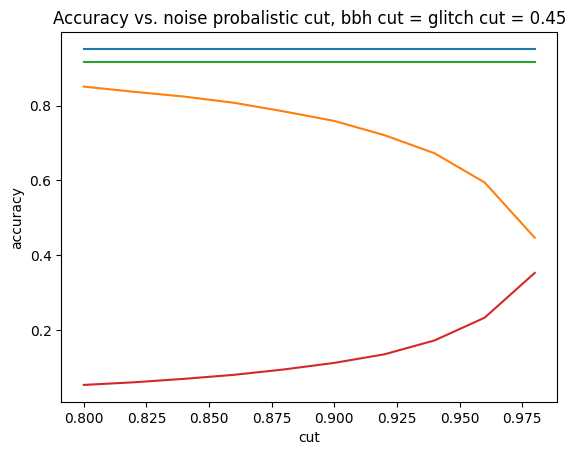

In [256]:
other_cut = 0.45

plt.plot(Sigmoid_cut_noise, accuracy[np.argwhere(np.logical_and(np.array(Sigmoid_cut)[:,0] == other_cut, np.array(Sigmoid_cut)[:,2] == other_cut)).astype(int).flatten()])
plt.title('Accuracy vs. noise probalistic cut, bbh cut = glitch cut = 0.45')
plt.xlabel('cut')
plt.ylabel('accuracy')

Text(0, 0.5, 'accuracy')

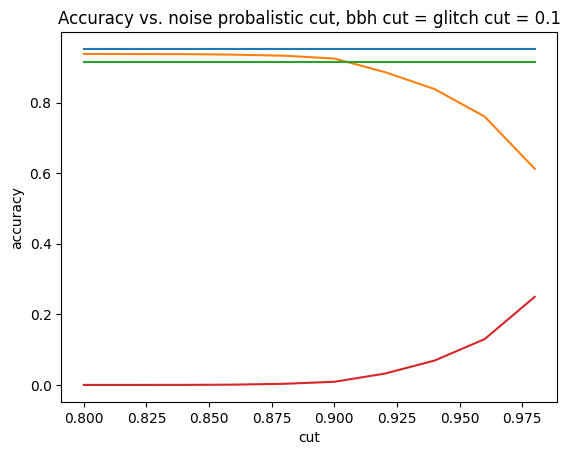

In [258]:
other_cut = 0.1

plt.plot(Sigmoid_cut_noise, accuracy[np.argwhere(np.logical_and(np.array(Sigmoid_cut)[:,0] == other_cut, np.array(Sigmoid_cut)[:,2] == other_cut)).astype(int).flatten()])
plt.title('Accuracy vs. noise probalistic cut, bbh cut = glitch cut = 0.1')
plt.xlabel('cut')
plt.ylabel('accuracy')

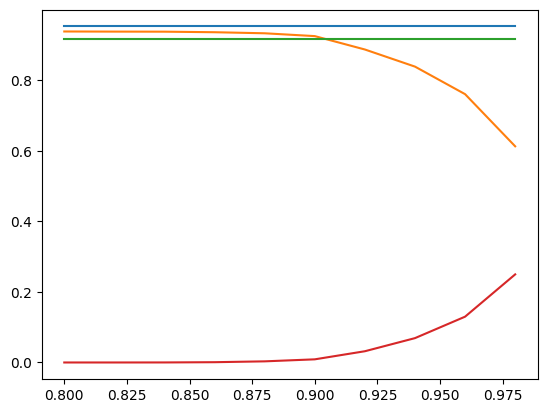

In [237]:
other_cut = 0.1

plt.plot(Sigmoid_cut_noise, accuracy[np.argwhere(np.logical_and(np.array(Sigmoid_cut)[:,0] == other_cut, np.array(Sigmoid_cut)[:,2] == other_cut)).astype(int).flatten()])

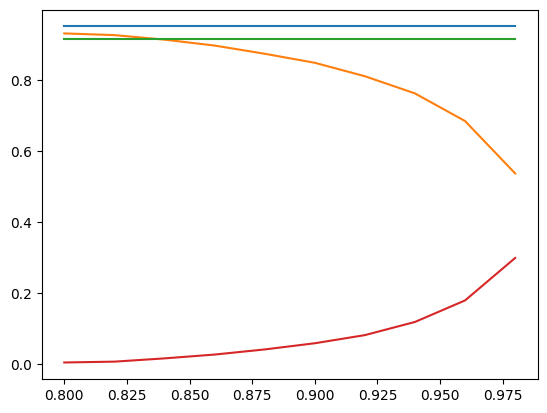

In [238]:
other_cut = 0.18

plt.plot(Sigmoid_cut_noise, accuracy[np.argwhere(np.logical_and(np.array(Sigmoid_cut)[:,0] == other_cut, np.array(Sigmoid_cut)[:,2] == other_cut)).astype(int).flatten()])

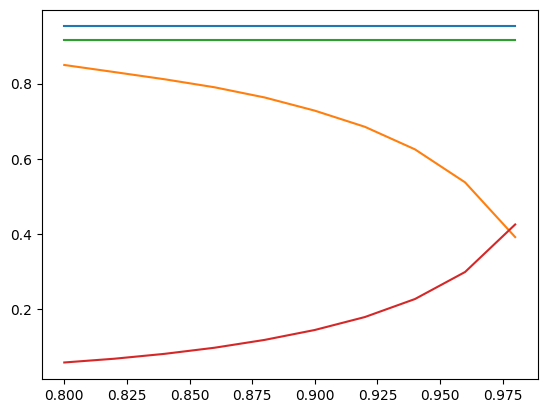

In [158]:
other_cut = 0.18

plt.plot(Sigmoid_cut_noise, accuracy[np.argwhere(np.logical_and(np.array(Sigmoid_cut)[:,0] == other_cut, np.array(Sigmoid_cut)[:,2] == other_cut)).astype(int).flatten()])

In [126]:
foo[:,1]

array([1.   , 0.696, 0.623, 0.567, 0.52 , 0.473, 0.428, 0.396, 0.364,
       0.334, 0.309, 0.289, 0.269, 0.252, 0.231, 0.217, 0.201, 0.184,
       0.169, 0.157, 0.148, 0.136, 0.125, 0.117, 0.11 , 0.104, 0.096,
       0.089, 0.079, 0.067, 0.062, 0.06 , 0.059, 0.056, 0.05 , 0.048,
       0.043, 0.038, 0.033, 0.024, 0.014, 0.002, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   ])

In [125]:
np.max(foo[:,1])

1.0

In [63]:
(resTest[3*nTest:].detach().numpy() == 0).sum() / nTest_g

0.952186928321969

In [73]:
np.all(np.array([0.25742987, 0.803871  , 0.42266008]) < 0.9)

True

In [87]:
np.all(nn.Sigmoid()(classifier(testData[2*nTest:3*nTest])).detach().numpy() < 0.9 * np.ones(3), axis = 1).sum()

2006

In [96]:
accuracy

array([[0.91518377, 0.75165   , 0.83165   , 0.15915   ],
       [0.91293863, 0.7328    , 0.82635   , 0.1711    ],
       [0.91094296, 0.7137    , 0.8207    , 0.18535   ],
       [0.90811575, 0.6923    , 0.8138    , 0.2033    ],
       [0.90470647, 0.6652    , 0.80625   , 0.22575   ],
       [0.89955097, 0.63015   , 0.7966    , 0.2544    ],
       [0.89497755, 0.58715   , 0.78325   , 0.2916    ],
       [0.88865791, 0.52715   , 0.7663    , 0.343     ],
       [0.87909529, 0.43935   , 0.74      , 0.41865   ],
       [0.86146682, 0.2937    , 0.69595   , 0.5512    ]])

In [93]:
accuracy

array([[0.93364377, 0.80595   , 0.87785   , 0.1003    ],
       [0.93156494, 0.78275   , 0.87015   , 0.1181    ],
       [0.92848828, 0.75455   , 0.86195   , 0.1422    ],
       [0.92599368, 0.71635   , 0.85165   , 0.1713    ],
       [0.92183602, 0.67285   , 0.8399    , 0.20935   ],
       [0.91709629, 0.61275   , 0.82245   , 0.25645   ],
       [0.91036088, 0.53455   , 0.80265   , 0.3227    ],
       [0.90279395, 0.4337    , 0.77475   , 0.41465   ],
       [0.88990521, 0.2924    , 0.73015   , 0.5507    ],
       [0.86778646, 0.1128    , 0.6494    , 0.76505   ]])

In [90]:
accuracy

array([[9.52186928e-01, 9.38000000e-01, 9.16000000e-01, 0.00000000e+00],
       [9.52186928e-01, 9.38000000e-01, 9.16000000e-01, 0.00000000e+00],
       [9.52186928e-01, 9.38000000e-01, 9.16000000e-01, 0.00000000e+00],
       [9.52186928e-01, 9.38000000e-01, 9.16000000e-01, 0.00000000e+00],
       [9.52186928e-01, 9.38000000e-01, 9.16000000e-01, 0.00000000e+00],
       [9.52186928e-01, 9.38000000e-01, 9.16000000e-01, 0.00000000e+00],
       [9.52186928e-01, 9.37750000e-01, 9.15950000e-01, 3.00000000e-04],
       [9.51105937e-01, 9.34450000e-01, 9.13950000e-01, 3.55000000e-03],
       [9.47280891e-01, 9.12850000e-01, 9.07050000e-01, 2.13000000e-02],
       [9.33643772e-01, 8.05950000e-01, 8.77850000e-01, 1.00300000e-01]])

In [27]:
outputTest = classifier(torch.FloatTensor(X_test))

In [28]:
resTest = torch.argmax(nn.Softmax(dim=1)(outputTest), dim=1)

In [ ]:
resTest

tensor([1, 1, 1,  ..., 3, 1, 0])

In [ ]:
target_test

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [ ]:
print(torch.eq(torch.tensor(target_test), resTest).sum().item())
print(torch.eq(torch.tensor(target_test), resTest).sum().item() / len(target_test))

54037
0.8715785738479653


In [ ]:
print(len(target_test) - torch.eq(torch.tensor(target_test>1), resTest<=1).sum().item())
print(1 - torch.eq(torch.tensor(target_test>1), resTest<=1).sum().item() / len(target_test))

55029
0.8875788319166438


In [423]:
resTest_beforeSM = nn.Softmax(dim=1)(outputTest).detach().numpy()

In [329]:
resTest_beforeSM

array([[4.1681228e-04, 9.2223912e-01, 7.7344015e-02],
       [3.9117658e-05, 9.9958402e-01, 3.7686288e-04],
       [3.0233059e-03, 7.0605010e-01, 2.9092655e-01],
       ...,
       [9.9408627e-01, 2.0756941e-04, 5.7061566e-03],
       [4.5225546e-03, 9.4580859e-01, 4.9668878e-02],
       [1.0000000e+00, 3.5767899e-11, 5.1789165e-08]], dtype=float32)

In [21]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_32220\1676876150.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


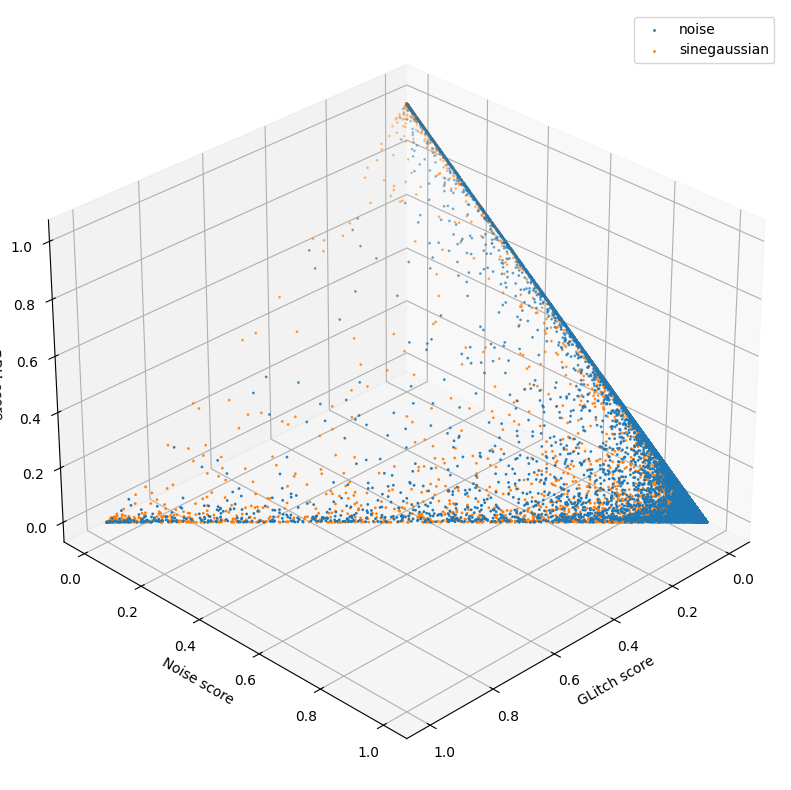

In [163]:
fig = plt.figure(figsize=(12,10))
ax1 = plt.axes(projection = '3d',computed_zorder=False)

ax1.scatter3D(resTest_beforeSM[:nTest][:,0], resTest_beforeSM[:nTest][:,1], resTest_beforeSM[:nTest][:,2], c = colors[0], s = 1, zorder = 5, label = 'noise')
# ax1.scatter3D(resTest_beforeSM[nTest:2*nTest][:,0], resTest_beforeSM[nTest:2*nTest][:,1], resTest_beforeSM[nTest:2*nTest][:,2], s = 1, label = 'bbh')
ax1.scatter3D(resTest_beforeSM[2 * nTest:3 * nTest][:,0], resTest_beforeSM[2 * nTest:3 * nTest][:,1], resTest_beforeSM[2 * nTest:3 * nTest][:,2], c = colors[1], s = 1, zorder = 0,label = 'sinegaussian')
# ax1.scatter3D(resTest_beforeSM[3 * nTest:][:,0], resTest_beforeSM[3 * nTest:][:,1], resTest_beforeSM[3 * nTest:][:,2], s = 1, label = 'glitch')
ax1.view_init(elev = 30, azim=45)

ax1.set_xlabel('GLitch score')
ax1.set_ylabel('Noise score')
ax1.set_zlabel('BBH score')

plt.legend()

fig.show()

C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_32220\2205444643.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


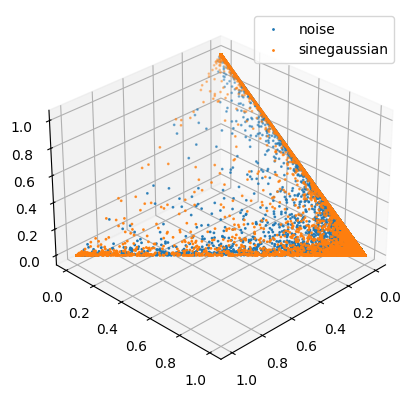

In [150]:
fig = plt.figure()
ax1 = plt.axes(projection = '3d')


ax1.scatter3D(resTest_beforeSM[:nTest][:,0], resTest_beforeSM[:nTest][:,1], resTest_beforeSM[:nTest][:,2], s = 1, label = 'noise')
ax1.scatter3D(resTest_beforeSM[2 * nTest:3 * nTest][:,0], resTest_beforeSM[2 * nTest:3 * nTest][:,1], resTest_beforeSM[2 * nTest:3 * nTest][:,2], s = 1, label = 'sinegaussian')


# ax1.scatter3D(resTest_beforeSM[nTest:2*nTest][:,0], resTest_beforeSM[nTest:2*nTest][:,1], resTest_beforeSM[nTest:2*nTest][:,2], s = 1, label = 'bbh')

# ax1.scatter3D(resTest_beforeSM[3 * nTest:][:,0], resTest_beforeSM[3 * nTest:][:,1], resTest_beforeSM[3 * nTest:][:,2], s = 1, label = 'glitch')
ax1.view_init(elev = 30, azim=45)

plt.legend()

fig.show()

C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_32220\3772117003.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


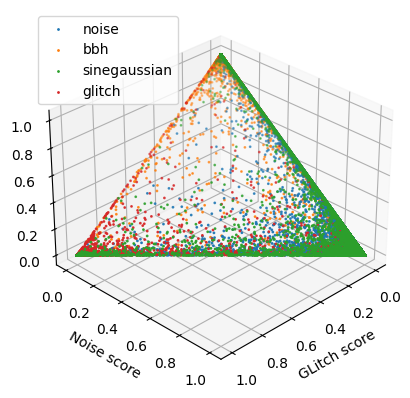

In [161]:
fig = plt.figure()
ax1 = plt.axes(projection = '3d')

ax1.scatter3D(resTest_beforeSM[:nTest][:,0], resTest_beforeSM[:nTest][:,1], resTest_beforeSM[:nTest][:,2], s = 1, label = 'noise')
ax1.scatter3D(resTest_beforeSM[nTest:2*nTest][:,0], resTest_beforeSM[nTest:2*nTest][:,1], resTest_beforeSM[nTest:2*nTest][:,2], s = 1, label = 'bbh')
ax1.scatter3D(resTest_beforeSM[2 * nTest:3 * nTest][:,0], resTest_beforeSM[2 * nTest:3 * nTest][:,1], resTest_beforeSM[2 * nTest:3 * nTest][:,2], s = 1, label = 'sinegaussian')
ax1.scatter3D(resTest_beforeSM[3 * nTest:][:,0], resTest_beforeSM[3 * nTest:][:,1], resTest_beforeSM[3 * nTest:][:,2], s = 1, label = 'glitch')
ax1.view_init(elev = 30, azim=45)

plt.legend()

fig.show()

C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_32220\2787919561.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


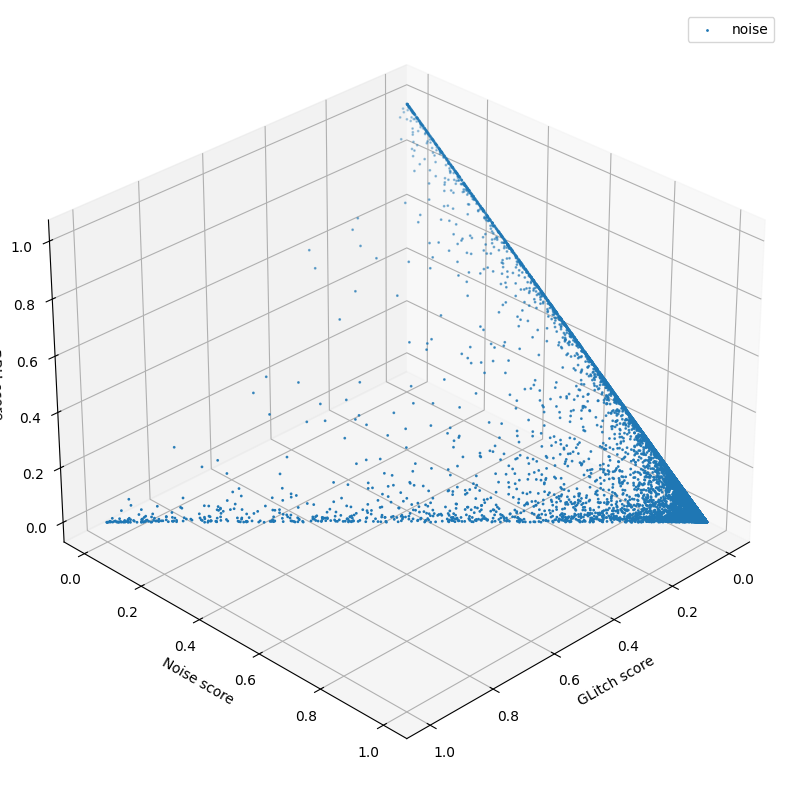

In [164]:
fig = plt.figure(figsize=(12,10))
ax1 = plt.axes(projection = '3d')

ax1.scatter3D(resTest_beforeSM[:nTest][:,0], resTest_beforeSM[:nTest][:,1], resTest_beforeSM[:nTest][:,2], s = 1, label = 'noise')
# ax1.scatter3D(resTest_beforeSM[nTest:2*nTest][:,0], resTest_beforeSM[nTest:2*nTest][:,1], resTest_beforeSM[nTest:2*nTest][:,2], s = 1, label = 'bbh')
# ax1.scatter3D(resTest_beforeSM[2 * nTest:3 * nTest][:,0], resTest_beforeSM[2 * nTest:3 * nTest][:,1], resTest_beforeSM[2 * nTest:3 * nTest][:,2], s = 1, label = 'sinegaussian')
# ax1.scatter3D(resTest_beforeSM[3 * nTest:][:,0], resTest_beforeSM[3 * nTest:][:,1], resTest_beforeSM[3 * nTest:][:,2], s = 1, label = 'glitch')
ax1.view_init(elev = 30, azim=45)

ax1.set_xlabel('GLitch score')
ax1.set_ylabel('Noise score')
ax1.set_zlabel('BBH score')


plt.legend()

fig.show()

C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_30376\2058859274.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


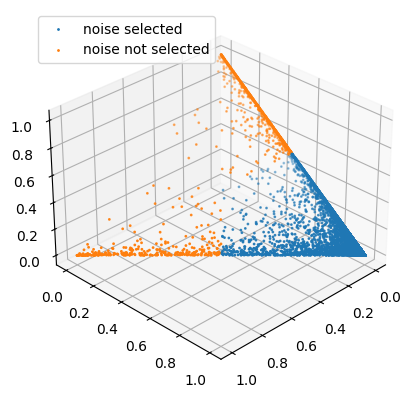

In [342]:
fig = plt.figure()
ax1 = plt.axes(projection = '3d')

ax1.scatter3D(resTest_beforeSM[:nTest][np.argwhere(resTest[:nTest] == 1).flatten()][:,0], resTest_beforeSM[:nTest][np.argwhere(resTest[:nTest] == 1).flatten()][:,1], resTest_beforeSM[:nTest][np.argwhere(resTest[:nTest] == 1).flatten()][:,2], s = 1, label = 'noise selected')
ax1.scatter3D(resTest_beforeSM[:nTest][np.argwhere(resTest[:nTest] != 1).flatten()][:,0], resTest_beforeSM[:nTest][np.argwhere(resTest[:nTest] != 1).flatten()][:,1], resTest_beforeSM[:nTest][np.argwhere(resTest[:nTest] != 1).flatten()][:,2], s = 1, label = 'noise not selected')
# ax1.scatter3D(resTest_beforeSM[nTest:2*nTest][:,0], resTest_beforeSM[nTest:2*nTest][:,1], resTest_beforeSM[nTest:2*nTest][:,2], s = 1, label = 'bbh')
# ax1.scatter3D(resTest_beforeSM[2 * nTest:3 * nTest][:,0], resTest_beforeSM[2 * nTest:3 * nTest][:,1], resTest_beforeSM[2 * nTest:3 * nTest][:,2], s = 1, label = 'sinegaussian')
# ax1.scatter3D(resTest_beforeSM[3 * nTest:][:,0], resTest_beforeSM[3 * nTest:][:,1], resTest_beforeSM[3 * nTest:][:,2], s = 1, label = 'glitch')
ax1.view_init(elev = 30, azim=45)

plt.legend()

fig.show()

C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_30376\3397659250.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


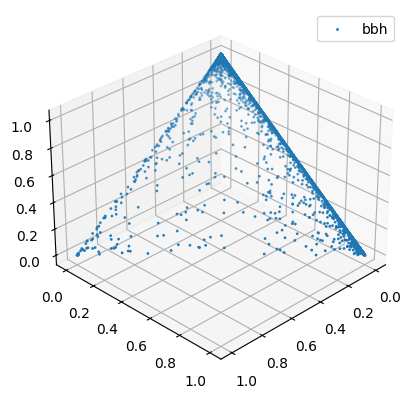

In [339]:
fig = plt.figure()
ax1 = plt.axes(projection = '3d')

# ax1.scatter3D(resTest_beforeSM[:nTest][:,0], resTest_beforeSM[:nTest][:,1], resTest_beforeSM[:nTest][:,2], s = 1, label = 'noise')
ax1.scatter3D(resTest_beforeSM[nTest:2*nTest][:,0], resTest_beforeSM[nTest:2*nTest][:,1], resTest_beforeSM[nTest:2*nTest][:,2], s = 1, label = 'bbh')
# ax1.scatter3D(resTest_beforeSM[2 * nTest:3 * nTest][:,0], resTest_beforeSM[2 * nTest:3 * nTest][:,1], resTest_beforeSM[2 * nTest:3 * nTest][:,2], s = 1, label = 'sinegaussian')
# ax1.scatter3D(resTest_beforeSM[3 * nTest:][:,0], resTest_beforeSM[3 * nTest:][:,1], resTest_beforeSM[3 * nTest:][:,2], s = 1, label = 'glitch')
ax1.view_init(elev = 30, azim=45)

plt.legend()

fig.show()

C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_32220\336812026.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


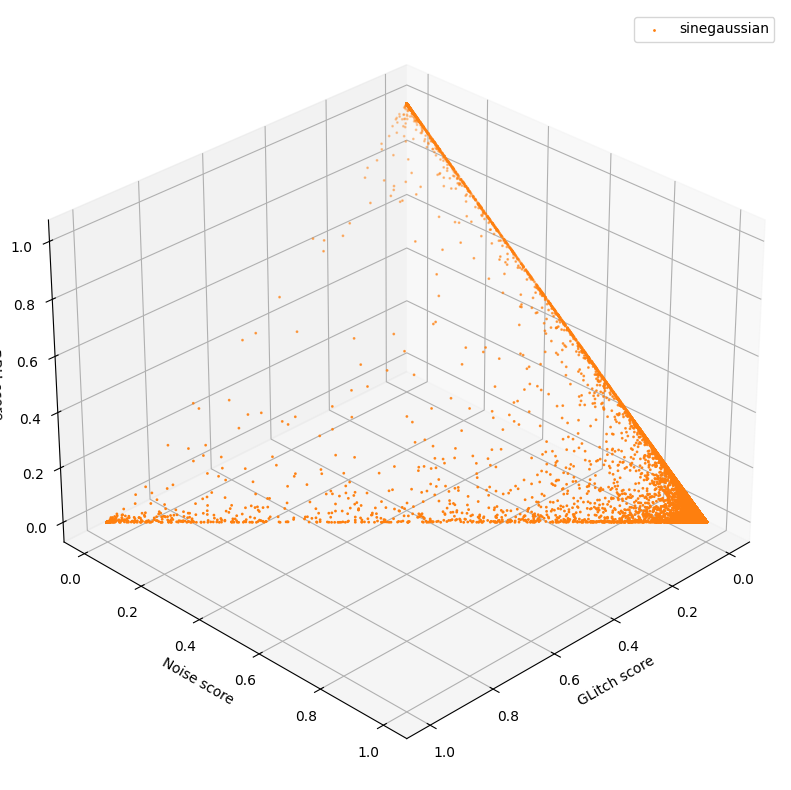

In [166]:
fig = plt.figure(figsize = (12,10))
ax1 = plt.axes(projection = '3d')

# ax1.scatter3D(resTest_beforeSM[:nTest][:,0], resTest_beforeSM[:nTest][:,1], resTest_beforeSM[:nTest][:,2], s = 1, label = 'noise')
# ax1.scatter3D(resTest_beforeSM[nTest:2*nTest][:,0], resTest_beforeSM[nTest:2*nTest][:,1], resTest_beforeSM[nTest:2*nTest][:,2], s = 1, label = 'bbh')
ax1.scatter3D(resTest_beforeSM[2 * nTest:3 * nTest][:,0], resTest_beforeSM[2 * nTest:3 * nTest][:,1], resTest_beforeSM[2 * nTest:3 * nTest][:,2], s = 1, c = colors[1],label = 'sinegaussian')
# ax1.scatter3D(resTest_beforeSM[3 * nTest:][:,0], resTest_beforeSM[3 * nTest:][:,1], resTest_beforeSM[3 * nTest:][:,2], s = 1, label = 'glitch')
ax1.view_init(elev = 30, azim=45)


ax1.set_xlabel('GLitch score')
ax1.set_ylabel('Noise score')
ax1.set_zlabel('BBH score')


plt.legend()

fig.show()

C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_8916\336812026.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


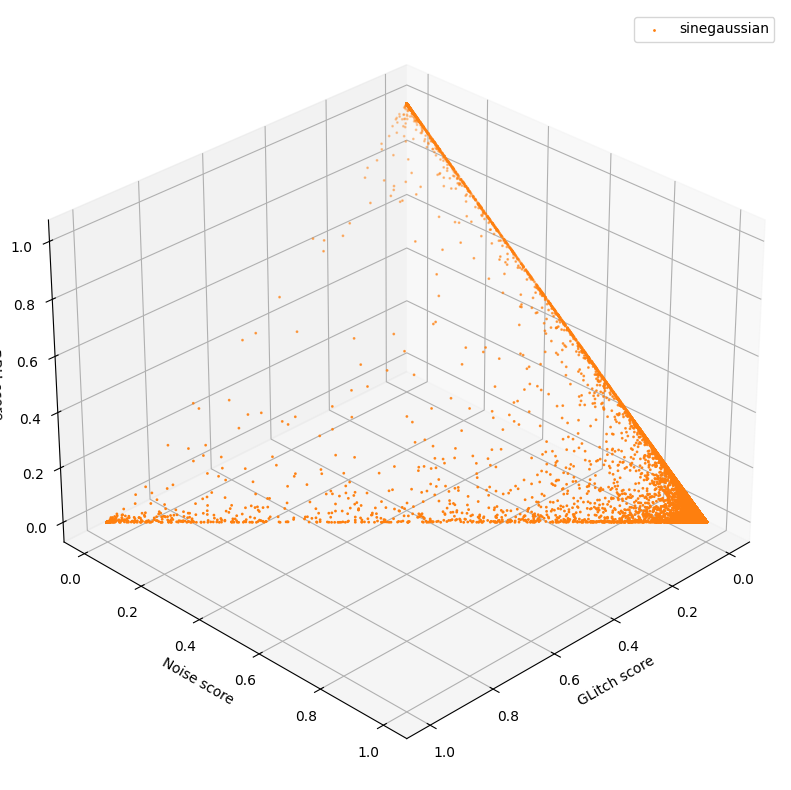

In [20]:
fig = plt.figure(figsize = (12,10))
ax1 = plt.axes(projection = '3d')

# ax1.scatter3D(resTest_beforeSM[:nTest][:,0], resTest_beforeSM[:nTest][:,1], resTest_beforeSM[:nTest][:,2], s = 1, label = 'noise')
# ax1.scatter3D(resTest_beforeSM[nTest:2*nTest][:,0], resTest_beforeSM[nTest:2*nTest][:,1], resTest_beforeSM[nTest:2*nTest][:,2], s = 1, label = 'bbh')
ax1.scatter3D(resTest_beforeSM[2 * nTest:3 * nTest][:,0], resTest_beforeSM[2 * nTest:3 * nTest][:,1], resTest_beforeSM[2 * nTest:3 * nTest][:,2], s = 1, c = colors[1],label = 'sinegaussian')
# ax1.scatter3D(resTest_beforeSM[3 * nTest:][:,0], resTest_beforeSM[3 * nTest:][:,1], resTest_beforeSM[3 * nTest:][:,2], s = 1, label = 'glitch')
ax1.view_init(elev = 30, azim=45)


ax1.set_xlabel('GLitch score')
ax1.set_ylabel('Noise score')
ax1.set_zlabel('BBH score')


plt.legend()

fig.show()

C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_30376\132908402.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


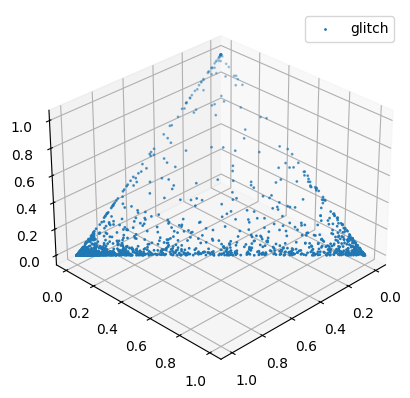

In [336]:
fig = plt.figure()
ax1 = plt.axes(projection = '3d')

# ax1.scatter3D(resTest_beforeSM[:nTest][:,0], resTest_beforeSM[:nTest][:,1], resTest_beforeSM[:nTest][:,2], s = 1, label = 'noise')
# ax1.scatter3D(resTest_beforeSM[nTest:2*nTest][:,0], resTest_beforeSM[nTest:2*nTest][:,1], resTest_beforeSM[nTest:2*nTest][:,2], s = 1, label = 'bbh')
# ax1.scatter3D(resTest_beforeSM[2 * nTest:3 * nTest][:,0], resTest_beforeSM[2 * nTest:3 * nTest][:,1], resTest_beforeSM[2 * nTest:3 * nTest][:,2], s = 1, label = 'sinegaussian')
ax1.scatter3D(resTest_beforeSM[3 * nTest:][:,0], resTest_beforeSM[3 * nTest:][:,1], resTest_beforeSM[3 * nTest:][:,2], s = 1, label = 'glitch')
ax1.view_init(elev = 30, azim=45)

plt.legend()

fig.show()

MemoryError: bad allocation

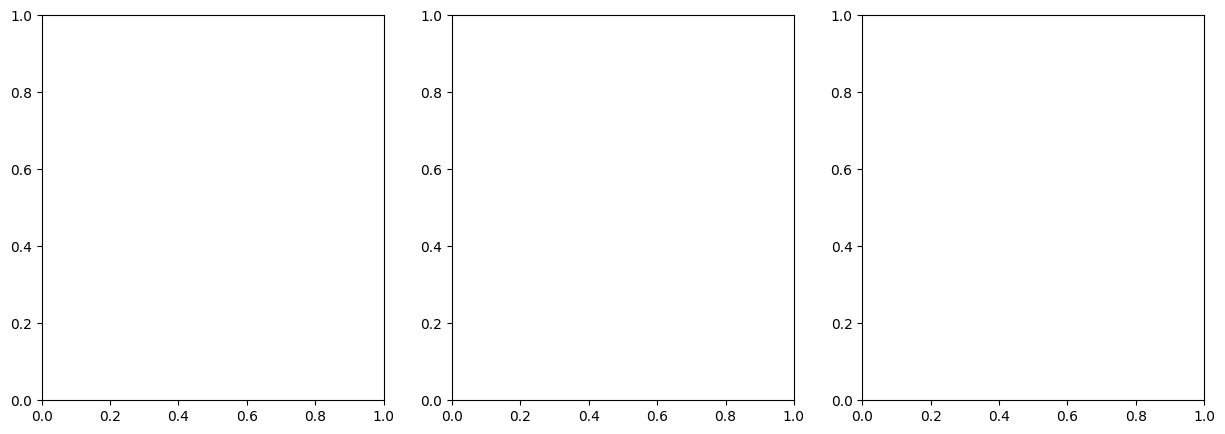

In [21]:
x = resTest_beforeSM[2 * nTest:3 * nTest][:,0]
y = resTest_beforeSM[2 * nTest:3 * nTest][:,1]
z = resTest_beforeSM[2 * nTest:3 * nTest][:,2]

X, Y = np.meshgrid(x, y)
Z = 1 - X - Y

# 创建三张 contour plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# 第一张图: x 和 y
ax1.contourf(X, Y, Z, levels=10)
ax1.set_xlabel('Glitch score')
ax1.set_ylabel('Noise score')
# ax1.set_title('Contour Plot of x and y')

# 第二张图: x 和 z
ax2.contourf(X, Z, Y, levels=10)
ax2.set_xlabel('Glitch score')
ax2.set_ylabel('BBH score')
# ax2.set_title('Contour Plot of x and z')

# 第三张图: y 和 z
ax3.contourf(Y, Z, X, levels=10)
ax3.set_xlabel('Noise score')
ax3.set_ylabel('BBH score')
# ax3.set_title('Contour Plot of y and z')

plt.tight_layout()
plt.show()

plt.savefig('../Pic_cached/ContourPlot_trial.png')

In [18]:
x = resTest_beforeSM[2 * nTest:3 * nTest][:,0]
y = resTest_beforeSM[2 * nTest:3 * nTest][:,1]
z = resTest_beforeSM[2 * nTest:3 * nTest][:,2]

X, Y = np.meshgrid(x, y)
Z = 1 - X - Y

# 设置分块大小
block_size = 500

# 创建三张 contour plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# 第一张图: x 和 y
for i in range(0, X.shape[0], block_size):
    for j in range(0, X.shape[1], block_size):
        ax1.contourf(X[i:i+block_size, j:j+block_size], 
                    Y[i:i+block_size, j:j+block_size], 
                    Z[i:i+block_size, j:j+block_size], levels=10)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Contour Plot of x and y')

# 第二张图: x 和 z
for i in range(0, X.shape[0], block_size):
    for j in range(0, Z.shape[1], block_size):
        ax2.contourf(X[i:i+block_size, :], 
                    Z[i:i+block_size, j:j+block_size], 
                    Y[i:i+block_size, :], levels=10)
ax2.set_xlabel('x')
ax2.set_ylabel('z')
ax2.set_title('Contour Plot of x and z')

# 第三张图: y 和 z
for i in range(0, Y.shape[0], block_size):
    for j in range(0, Z.shape[1], block_size):
        ax3.contourf(Y[i:i+block_size, :], 
                    Z[i:i+block_size, j:j+block_size], 
                    X[i:i+block_size, :], levels=10)
ax3.set_xlabel('y')
ax3.set_ylabel('z')
ax3.set_title('Contour Plot of y and z')

plt.tight_layout()
plt.show()

plt.savefig('../Pic_cached/ContourPlot_trial.png')

TypeError: Shapes of y (500, 500) and z (500, 20000) do not match

Error in callback <function _draw_all_if_interactive at 0x000001B10ED827A0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001B10ED9C540> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [22]:
x = resTest_beforeSM[2 * nTest:3 * nTest][:,0]
y = resTest_beforeSM[2 * nTest:3 * nTest][:,1]
z = resTest_beforeSM[2 * nTest:3 * nTest][:,2]

In [122]:
bins_x = np.arange(0,1.01,0.01)
bins_y = np.arange(0,1.01,0.01)
hist, x_edges, y_edges = np.histogram2d(x,y,bins=[bins_x, bins_y])
density = (hist - 2 * hist.sum()) / (2 * hist.sum())

In [123]:
density.max()

-0.78755

In [127]:
bins_x.shape

(101,)

In [125]:
# density = np.log(density)

(0.0, 20.0)

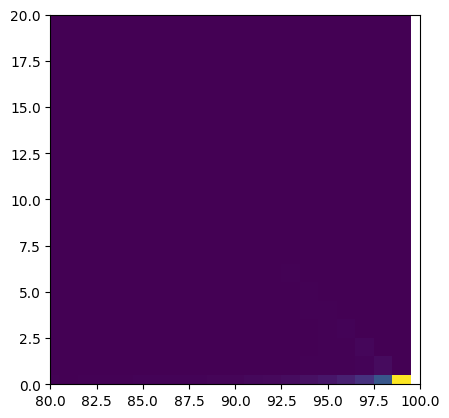

In [126]:
plt.imshow(density, origin = 'lower')
plt.xlim(80,100)
plt.ylim(0,20)

TypeError: len() of unsized object

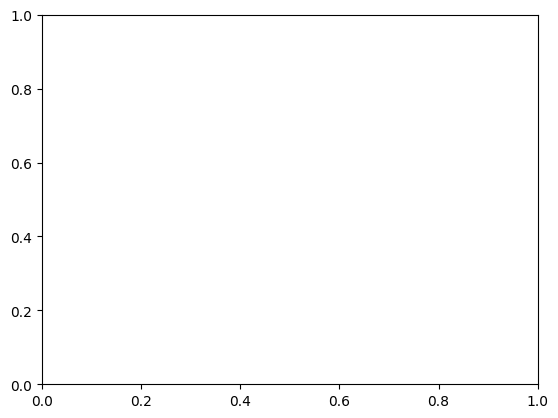

In [81]:
plt.contour((bins_x[:-1] + bins_x[1:])/2, (bins_y[:-1] + bins_y[1:])/2, density, 0.8)
plt.xlim(0.8,1)
plt.ylim(0,0.2)

In [14]:
outputTest = classifier(torch.FloatTensor(X_test))

In [15]:
outputTest

tensor([[ -5.6166,   1.9048,  -2.0237],
        [ -7.3326,   6.1077,  -8.1376],
        [ -5.1250,   2.5795,  -2.7489],
        ...,
        [  7.6213, -10.5225,  -7.4971],
        [ -3.4895,   2.7387,  -3.2551],
        [  5.5886, -14.1174,  -5.2743]], grad_fn=<AddmmBackward0>)

In [52]:
resTest_beforeSM = nn.Sigmoid()(outputTest).detach().numpy()

In [53]:
resTest = np.argmax(outputTest.detach().numpy(), axis = 1)

In [54]:
resTest

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [55]:
resTest_beforeSM.shape

(72026, 3)

In [56]:
resTest_beforeSM

array([[6.2953159e-06, 6.4605850e-01, 3.6096936e-01],
       [3.3953409e-05, 9.9854773e-01, 9.2573237e-04],
       [1.7336056e-04, 9.9704081e-01, 2.0952078e-03],
       ...,
       [9.9742717e-01, 5.9731019e-07, 6.9263675e-03],
       [9.9776316e-01, 5.5224020e-03, 2.7338225e-05],
       [9.9918574e-01, 8.9167762e-12, 2.7303207e-05]], dtype=float32)

In [57]:
np.set_printoptions(suppress = True)

In [31]:
np.savetxt('../Data_cached/Sigmoid_200-32-8-3.txt', resTest_beforeSM,fmt='%f')

In [58]:
nTest

20000

C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_32220\698412557.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


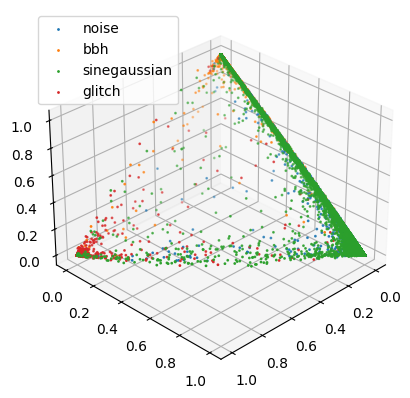

In [59]:
fig = plt.figure()
ax1 = plt.axes(projection = '3d')

ax1.scatter3D(resTest_beforeSM[:nTest][:,0], resTest_beforeSM[:nTest][:,1], resTest_beforeSM[:nTest][:,2], s = 1, label = 'noise')
ax1.scatter3D(resTest_beforeSM[nTest:2*nTest][:,0], resTest_beforeSM[nTest:2*nTest][:,1], resTest_beforeSM[nTest:2*nTest][:,2], s = 1, label = 'bbh')
ax1.scatter3D(resTest_beforeSM[2 * nTest:3 * nTest][:,0], resTest_beforeSM[2 * nTest:3 * nTest][:,1], resTest_beforeSM[2 * nTest:3 * nTest][:,2], s = 1, label = 'sinegaussian')
ax1.scatter3D(resTest_beforeSM[3 * nTest:][:,0], resTest_beforeSM[3 * nTest:][:,1], resTest_beforeSM[3 * nTest:][:,2], s = 1, label = 'glitch')
ax1.view_init(elev = 30, azim=45)

plt.legend()

fig.show()

C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_32220\698412557.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


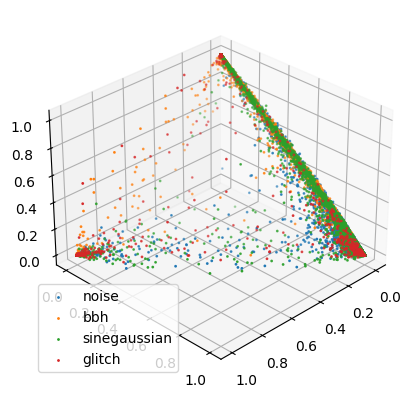

In [139]:
fig = plt.figure()
ax1 = plt.axes(projection = '3d')

ax1.scatter3D(resTest_beforeSM[:nTest][:,0], resTest_beforeSM[:nTest][:,1], resTest_beforeSM[:nTest][:,2], s = 1, label = 'noise')
ax1.scatter3D(resTest_beforeSM[nTest:2*nTest][:,0], resTest_beforeSM[nTest:2*nTest][:,1], resTest_beforeSM[nTest:2*nTest][:,2], s = 1, label = 'bbh')
ax1.scatter3D(resTest_beforeSM[2 * nTest:3 * nTest][:,0], resTest_beforeSM[2 * nTest:3 * nTest][:,1], resTest_beforeSM[2 * nTest:3 * nTest][:,2], s = 1, label = 'sinegaussian')
ax1.scatter3D(resTest_beforeSM[3 * nTest:][:,0], resTest_beforeSM[3 * nTest:][:,1], resTest_beforeSM[3 * nTest:][:,2], s = 1, label = 'glitch')
ax1.view_init(elev = 30, azim=45)

plt.legend()

fig.show()

C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_32220\2058859274.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


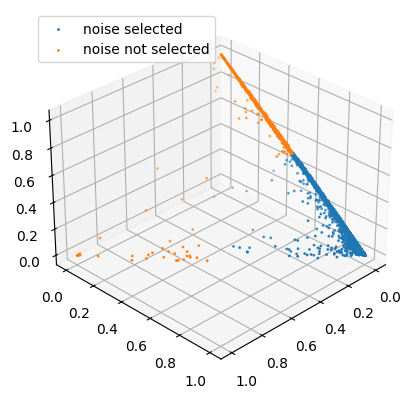

In [60]:
fig = plt.figure()
ax1 = plt.axes(projection = '3d')

ax1.scatter3D(resTest_beforeSM[:nTest][np.argwhere(resTest[:nTest] == 1).flatten()][:,0], resTest_beforeSM[:nTest][np.argwhere(resTest[:nTest] == 1).flatten()][:,1], resTest_beforeSM[:nTest][np.argwhere(resTest[:nTest] == 1).flatten()][:,2], s = 1, label = 'noise selected')
ax1.scatter3D(resTest_beforeSM[:nTest][np.argwhere(resTest[:nTest] != 1).flatten()][:,0], resTest_beforeSM[:nTest][np.argwhere(resTest[:nTest] != 1).flatten()][:,1], resTest_beforeSM[:nTest][np.argwhere(resTest[:nTest] != 1).flatten()][:,2], s = 1, label = 'noise not selected')
# ax1.scatter3D(resTest_beforeSM[nTest:2*nTest][:,0], resTest_beforeSM[nTest:2*nTest][:,1], resTest_beforeSM[nTest:2*nTest][:,2], s = 1, label = 'bbh')
# ax1.scatter3D(resTest_beforeSM[2 * nTest:3 * nTest][:,0], resTest_beforeSM[2 * nTest:3 * nTest][:,1], resTest_beforeSM[2 * nTest:3 * nTest][:,2], s = 1, label = 'sinegaussian')
# ax1.scatter3D(resTest_beforeSM[3 * nTest:][:,0], resTest_beforeSM[3 * nTest:][:,1], resTest_beforeSM[3 * nTest:][:,2], s = 1, label = 'glitch')
ax1.view_init(elev = 30, azim=45)

plt.legend()

fig.show()

C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_32220\562391499.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


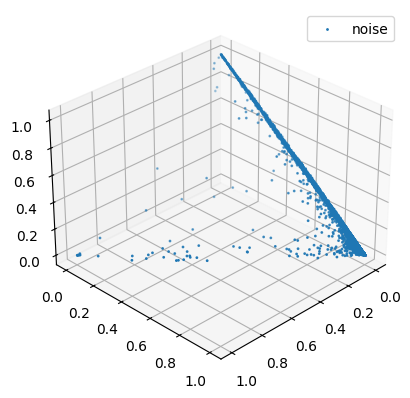

In [61]:
fig = plt.figure()
ax1 = plt.axes(projection = '3d')

ax1.scatter3D(resTest_beforeSM[:nTest][:,0], resTest_beforeSM[:nTest][:,1], resTest_beforeSM[:nTest][:,2], s = 1, label = 'noise')
# ax1.scatter3D(resTest_beforeSM[nTest:2*nTest][:,0], resTest_beforeSM[nTest:2*nTest][:,1], resTest_beforeSM[nTest:2*nTest][:,2], s = 1, label = 'bbh')
# ax1.scatter3D(resTest_beforeSM[2 * nTest:3 * nTest][:,0], resTest_beforeSM[2 * nTest:3 * nTest][:,1], resTest_beforeSM[2 * nTest:3 * nTest][:,2], s = 1, label = 'sinegaussian')
# ax1.scatter3D(resTest_beforeSM[3 * nTest:][:,0], resTest_beforeSM[3 * nTest:][:,1], resTest_beforeSM[3 * nTest:][:,2], s = 1, label = 'glitch')
ax1.view_init(elev = 30, azim=45)
 
plt.legend()

fig.show()

C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_32220\3397659250.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


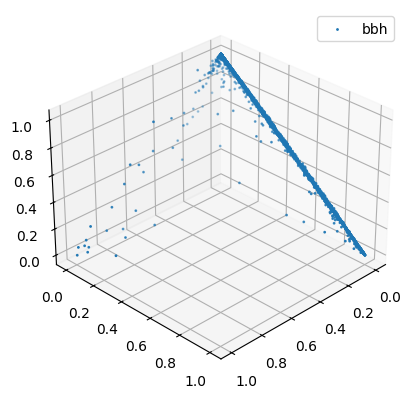

In [62]:
fig = plt.figure()
ax1 = plt.axes(projection = '3d')

# ax1.scatter3D(resTest_beforeSM[:nTest][:,0], resTest_beforeSM[:nTest][:,1], resTest_beforeSM[:nTest][:,2], s = 1, label = 'noise')
ax1.scatter3D(resTest_beforeSM[nTest:2*nTest][:,0], resTest_beforeSM[nTest:2*nTest][:,1], resTest_beforeSM[nTest:2*nTest][:,2], s = 1, label = 'bbh')
# ax1.scatter3D(resTest_beforeSM[2 * nTest:3 * nTest][:,0], resTest_beforeSM[2 * nTest:3 * nTest][:,1], resTest_beforeSM[2 * nTest:3 * nTest][:,2], s = 1, label = 'sinegaussian')
# ax1.scatter3D(resTest_beforeSM[3 * nTest:][:,0], resTest_beforeSM[3 * nTest:][:,1], resTest_beforeSM[3 * nTest:][:,2], s = 1, label = 'glitch')
ax1.view_init(elev = 30, azim=45)

plt.legend()

fig.show()

C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_32220\1475906022.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


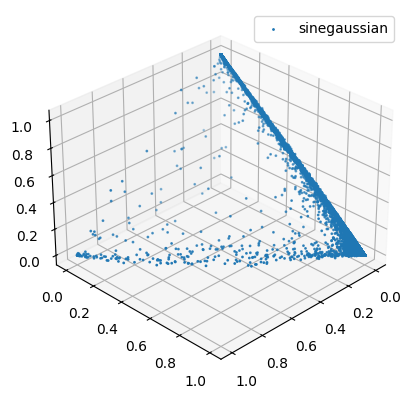

In [66]:
fig = plt.figure()
ax1 = plt.axes(projection = '3d')

# ax1.scatter3D(resTest_beforeSM[:nTest][:,0], resTest_beforeSM[:nTest][:,1], resTest_beforeSM[:nTest][:,2], s = 1, label = 'noise')
# ax1.scatter3D(resTest_beforeSM[nTest:2*nTest][:,0], resTest_beforeSM[nTest:2*nTest][:,1], resTest_beforeSM[nTest:2*nTest][:,2], s = 1, label = 'bbh')
ax1.scatter3D(resTest_beforeSM[2 * nTest:3 * nTest][:,0], resTest_beforeSM[2 * nTest:3 * nTest][:,1], resTest_beforeSM[2 * nTest:3 * nTest][:,2], s = 1, label = 'sinegaussian')
# ax1.scatter3D(resTest_beforeSM[3 * nTest:][:,0], resTest_beforeSM[3 * nTest:][:,1], resTest_beforeSM[3 * nTest:][:,2], s = 1, label = 'glitch')
ax1.view_init(elev = 30, azim=45)

plt.legend()

fig.show()

C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_32220\1475906022.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


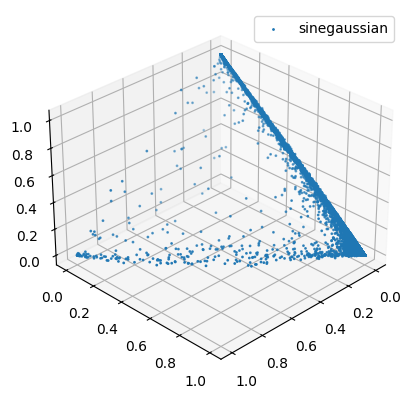

In [63]:
fig = plt.figure()
ax1 = plt.axes(projection = '3d')

# ax1.scatter3D(resTest_beforeSM[:nTest][:,0], resTest_beforeSM[:nTest][:,1], resTest_beforeSM[:nTest][:,2], s = 1, label = 'noise')
# ax1.scatter3D(resTest_beforeSM[nTest:2*nTest][:,0], resTest_beforeSM[nTest:2*nTest][:,1], resTest_beforeSM[nTest:2*nTest][:,2], s = 1, label = 'bbh')
ax1.scatter3D(resTest_beforeSM[2 * nTest:3 * nTest][:,0], resTest_beforeSM[2 * nTest:3 * nTest][:,1], resTest_beforeSM[2 * nTest:3 * nTest][:,2], s = 1, label = 'sinegaussian')
# ax1.scatter3D(resTest_beforeSM[3 * nTest:][:,0], resTest_beforeSM[3 * nTest:][:,1], resTest_beforeSM[3 * nTest:][:,2], s = 1, label = 'glitch')
ax1.view_init(elev = 30, azim=45)

plt.legend()

fig.show()

C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_32220\1733538228.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


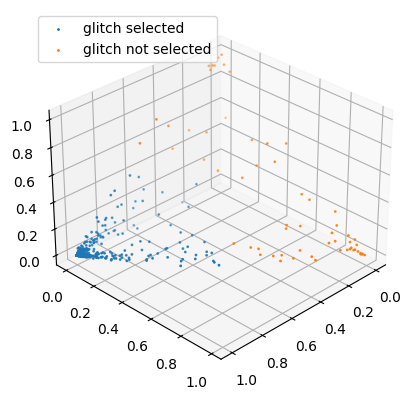

In [64]:
# %matplotlib qt
fig = plt.figure()
ax1 = plt.axes(projection = '3d')

# ax1.scatter3D(resTest_beforeSM[:nTest][:,0], resTest_beforeSM[:nTest][:,1], resTest_beforeSM[:nTest][:,2], s = 1, label = 'noise')
# ax1.scatter3D(resTest_beforeSM[nTest:2*nTest][:,0], resTest_beforeSM[nTest:2*nTest][:,1], resTest_beforeSM[nTest:2*nTest][:,2], s = 1, label = 'bbh')
# ax1.scatter3D(resTest_beforeSM[2 * nTest:3 * nTest][:,0], resTest_beforeSM[2 * nTest:3 * nTest][:,1], resTest_beforeSM[2 * nTest:3 * nTest][:,2], s = 1, label = 'sinegaussian')
ax1.scatter3D(resTest_beforeSM[3 * nTest:][np.argwhere(resTest[3 * nTest: ] == 0).flatten()][:,0], resTest_beforeSM[3 * nTest:][np.argwhere(resTest[3 * nTest: ] == 0).flatten()][:,1], resTest_beforeSM[3 * nTest:][np.argwhere(resTest[3 * nTest:] == 0).flatten()][:,2], s = 1, label = 'glitch selected')
ax1.scatter3D(resTest_beforeSM[3 * nTest:][np.argwhere(resTest[3 * nTest: ] != 0).flatten()][:,0], resTest_beforeSM[3 * nTest:][np.argwhere(resTest[3 * nTest: ] != 0).flatten()][:,1], resTest_beforeSM[3 * nTest:][np.argwhere(resTest[3 * nTest:] != 0).flatten()][:,2], s = 1, label = 'glitch not selected')
ax1.view_init(elev = 30, azim=45)

plt.legend()

fig.show()

In [479]:
resTest_beforeSM[3 * nTest:].shape

(12026, 3)

In [49]:
resTest[3 * nTest:].shape

(12026,)

In [48]:
np.argwhere(resTest[3 * nTest:] == 0).shape

(11585, 1)

In [65]:
classifier

SLDNN(
  (fc1): Linear(in_features=101, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=3, bias=True)
  (act): ReLU()
)

### Distribution Plot

#### Distribution in noise channel, noise vs. sinegaussian 101-32-8-3, SG as anomaly

In [185]:
bins = np.arange(0,1,0.01)

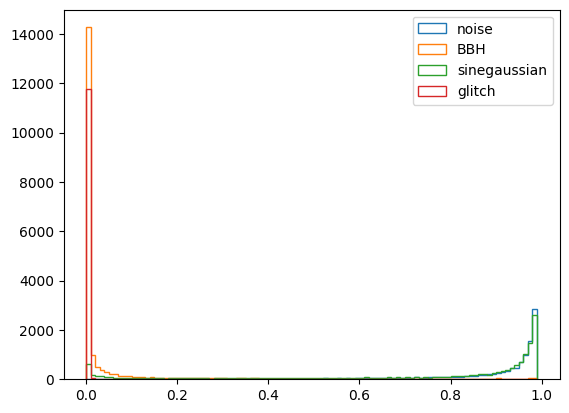

In [71]:
plt.hist(resTest_beforeSM[:nTest][:,1], histtype='step', label = 'noise', bins = bins, density=True)
plt.hist(resTest_beforeSM[nTest : 2 * nTest][:,1], histtype='step', label = 'BBH', bins = bins, density=True)
plt.hist(resTest_beforeSM[2 * nTest:3 * nTest][:,1], histtype='step', label = 'sinegaussian', bins = bins, density=True)
plt.hist(resTest_beforeSM[3 * nTest:][:,1], histtype='step', label = 'glitch', bins = bins, density=True)
plt.legend()

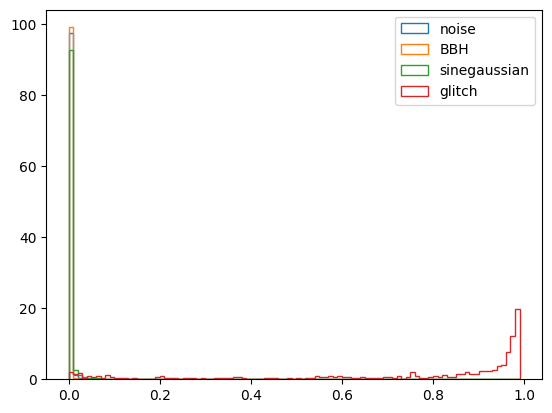

In [74]:
plt.hist(resTest_beforeSM[:nTest][:,0], histtype='step', label = 'noise', bins = bins, density=True)
plt.hist(resTest_beforeSM[nTest : 2 * nTest][:,0], histtype='step', label = 'BBH', bins = bins, density=True)
plt.hist(resTest_beforeSM[2 * nTest:3 * nTest][:,0], histtype='step', label = 'sinegaussian', bins = bins, density=True)
plt.hist(resTest_beforeSM[3 * nTest:][:,0], histtype='step', label = 'glitch', bins = bins, density=True)
plt.legend()

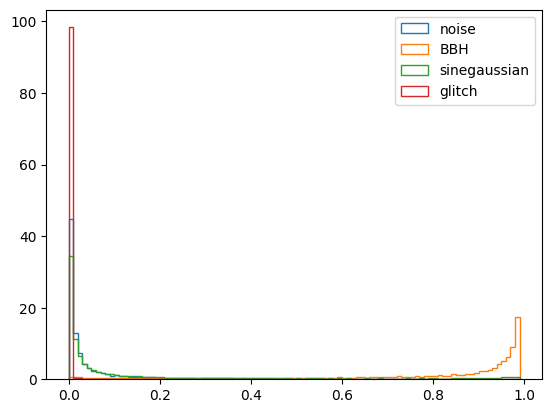

In [75]:
plt.hist(resTest_beforeSM[:nTest][:,2], histtype='step', label = 'noise', bins = bins, density=True)
plt.hist(resTest_beforeSM[nTest : 2 * nTest][:,2], histtype='step', label = 'BBH', bins = bins, density=True)
plt.hist(resTest_beforeSM[2 * nTest:3 * nTest][:,2], histtype='step', label = 'sinegaussian', bins = bins, density=True)
plt.hist(resTest_beforeSM[3 * nTest:][:,2], histtype='step', label = 'glitch', bins = bins, density=True)
plt.legend()

#### Distribution of 3 channels, 200-32-8-3, sg as anomaly

In [92]:
bins = np.arange(0,1,0.01)

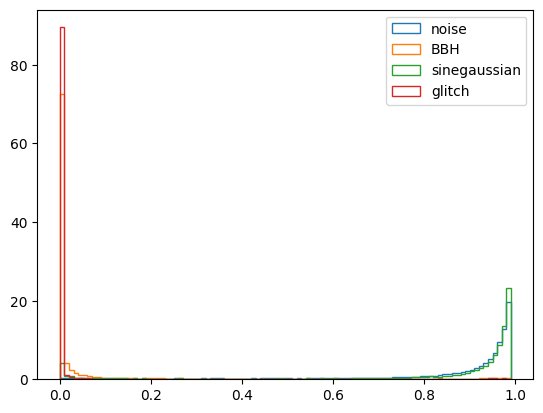

In [93]:
plt.hist(resTest_beforeSM[:nTest][:,1], histtype='step', label = 'noise', bins = bins, density=True)
plt.hist(resTest_beforeSM[nTest : 2 * nTest][:,1], histtype='step', label = 'BBH', bins = bins, density=True)
plt.hist(resTest_beforeSM[2 * nTest:3 * nTest][:,1], histtype='step', label = 'sinegaussian', bins = bins, density=True)
plt.hist(resTest_beforeSM[3 * nTest:][:,1], histtype='step', label = 'glitch', bins = bins, density=True)
plt.legend()

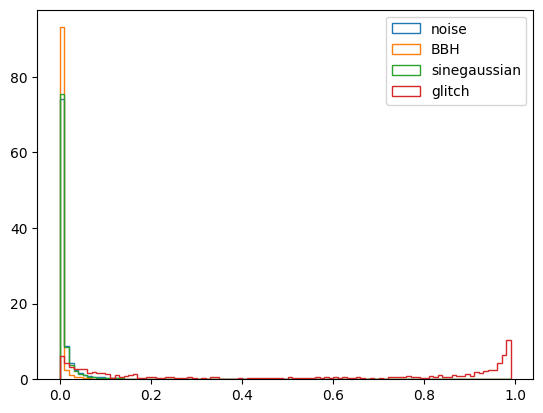

In [94]:
plt.hist(resTest_beforeSM[:nTest][:,0], histtype='step', label = 'noise', bins = bins, density=True)
plt.hist(resTest_beforeSM[nTest : 2 * nTest][:,0], histtype='step', label = 'BBH', bins = bins, density=True)
plt.hist(resTest_beforeSM[2 * nTest:3 * nTest][:,0], histtype='step', label = 'sinegaussian', bins = bins, density=True)
plt.hist(resTest_beforeSM[3 * nTest:][:,0], histtype='step', label = 'glitch', bins = bins, density=True)
plt.legend()

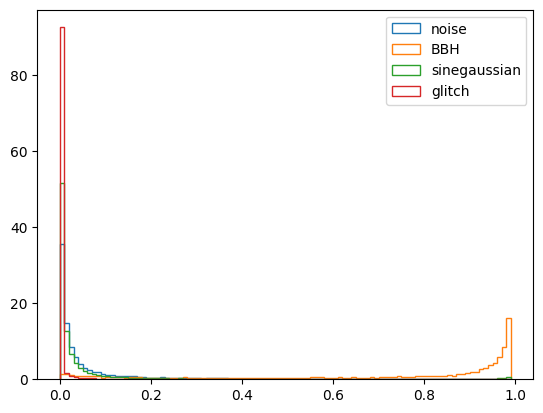

In [95]:
plt.hist(resTest_beforeSM[:nTest][:,2], histtype='step', label = 'noise', bins = bins, density=True)
plt.hist(resTest_beforeSM[nTest : 2 * nTest][:,2], histtype='step', label = 'BBH', bins = bins, density=True)
plt.hist(resTest_beforeSM[2 * nTest:3 * nTest][:,2], histtype='step', label = 'sinegaussian', bins = bins, density=True)
plt.hist(resTest_beforeSM[3 * nTest:][:,2], histtype='step', label = 'glitch', bins = bins, density=True)
plt.legend()

In [ ]:
bins = np.arange(0,1,0.01)

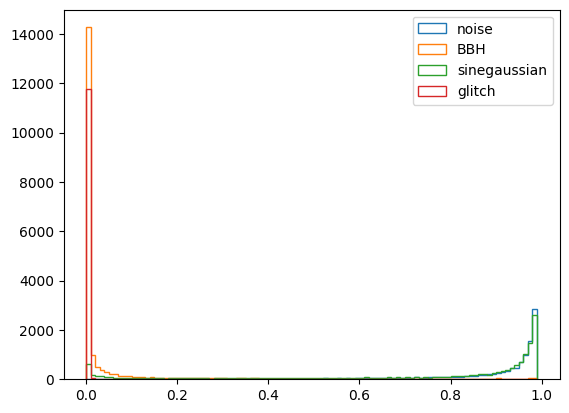

In [ ]:
plt.hist(resTest_beforeSM[:nTest][:,1], histtype='step', label = 'noise', bins = bins, density=True)
plt.hist(resTest_beforeSM[nTest : 2 * nTest][:,1], histtype='step', label = 'BBH', bins = bins, density=True)
plt.hist(resTest_beforeSM[2 * nTest:3 * nTest][:,1], histtype='step', label = 'sinegaussian', bins = bins, density=True)
plt.hist(resTest_beforeSM[3 * nTest:][:,1], histtype='step', label = 'glitch', bins = bins, density=True)
plt.legend()

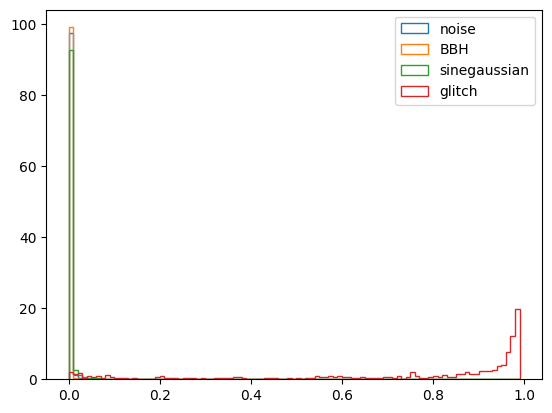

In [ ]:
plt.hist(resTest_beforeSM[:nTest][:,0], histtype='step', label = 'noise', bins = bins, density=True)
plt.hist(resTest_beforeSM[nTest : 2 * nTest][:,0], histtype='step', label = 'BBH', bins = bins, density=True)
plt.hist(resTest_beforeSM[2 * nTest:3 * nTest][:,0], histtype='step', label = 'sinegaussian', bins = bins, density=True)
plt.hist(resTest_beforeSM[3 * nTest:][:,0], histtype='step', label = 'glitch', bins = bins, density=True)
plt.legend()

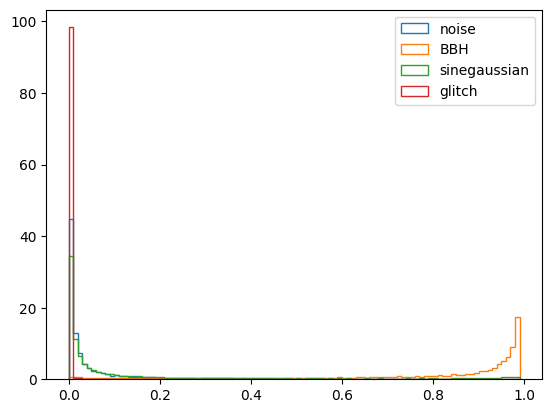

In [ ]:
plt.hist(resTest_beforeSM[:nTest][:,2], histtype='step', label = 'noise', bins = bins, density=True)
plt.hist(resTest_beforeSM[nTest : 2 * nTest][:,2], histtype='step', label = 'BBH', bins = bins, density=True)
plt.hist(resTest_beforeSM[2 * nTest:3 * nTest][:,2], histtype='step', label = 'sinegaussian', bins = bins, density=True)
plt.hist(resTest_beforeSM[3 * nTest:][:,2], histtype='step', label = 'glitch', bins = bins, density=True)
plt.legend()

#### Distribution of 3 channels, 200-64-16-3, sg as anomaly

In [108]:
classifier

SLDNN(
  (fc1): Linear(in_features=200, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=3, bias=True)
  (act): ReLU()
)

In [101]:
bins = np.arange(0,1,0.01)

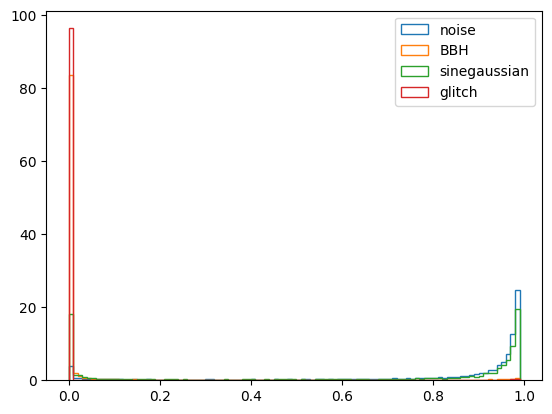

In [102]:
plt.hist(resTest_beforeSM[:nTest][:,1], histtype='step', label = 'noise', bins = bins, density=True)
plt.hist(resTest_beforeSM[nTest : 2 * nTest][:,1], histtype='step', label = 'BBH', bins = bins, density=True)
plt.hist(resTest_beforeSM[2 * nTest:3 * nTest][:,1], histtype='step', label = 'sinegaussian', bins = bins, density=True)
plt.hist(resTest_beforeSM[3 * nTest:][:,1], histtype='step', label = 'glitch', bins = bins, density=True)
plt.legend()

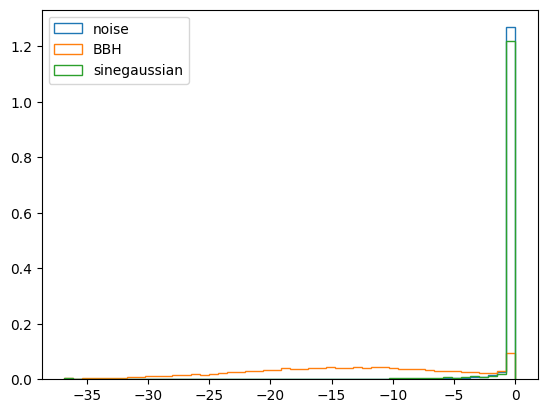

In [114]:
plt.hist(np.log(resTest_beforeSM[:nTest][:,1] + 1e-16), histtype='step', label = 'noise', bins = 50, density=True)
plt.hist(np.log(resTest_beforeSM[nTest : 2 * nTest][:,1]+1e-16), histtype='step', label = 'BBH', bins = 50, density=True)
plt.hist(np.log(resTest_beforeSM[2 * nTest:3 * nTest][:,1] + 1e-16), histtype='step', label = 'sinegaussian', bins = 50, density=True)
# plt.hist(np.log(resTest_beforeSM[3 * nTest:][:,1] + 1e-16), histtype='step', label = 'glitch', bins = 50, density=True)
plt.legend()
# plt.xscale('log')

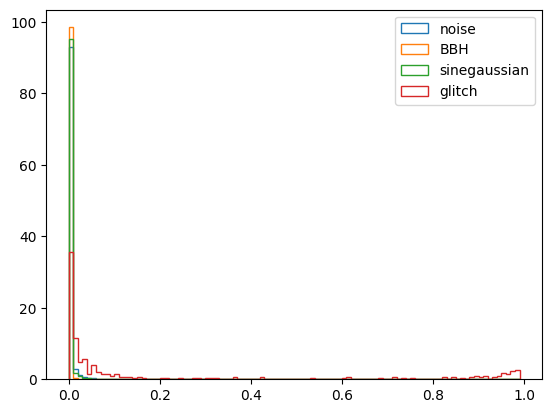

In [103]:
plt.hist(resTest_beforeSM[:nTest][:,0], histtype='step', label = 'noise', bins = bins, density=True)
plt.hist(resTest_beforeSM[nTest : 2 * nTest][:,0], histtype='step', label = 'BBH', bins = bins, density=True)
plt.hist(resTest_beforeSM[2 * nTest:3 * nTest][:,0], histtype='step', label = 'sinegaussian', bins = bins, density=True)
plt.hist(resTest_beforeSM[3 * nTest:][:,0], histtype='step', label = 'glitch', bins = bins, density=True)
plt.legend()

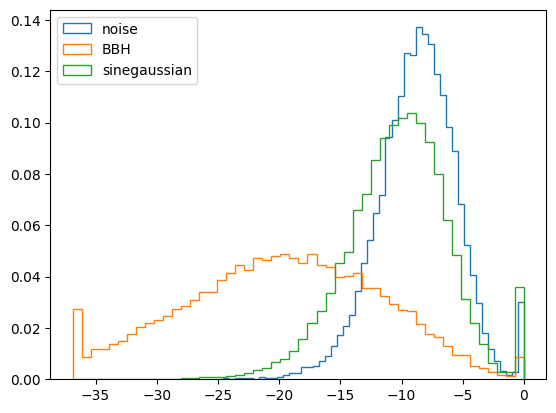

In [115]:
plt.hist(np.log(resTest_beforeSM[:nTest][:,0] + 1e-16), histtype='step', label = 'noise', bins = 50, density=True)
plt.hist(np.log(resTest_beforeSM[nTest : 2 * nTest][:,0]+1e-16), histtype='step', label = 'BBH', bins = 50, density=True)
plt.hist(np.log(resTest_beforeSM[2 * nTest:3 * nTest][:,0] + 1e-16), histtype='step', label = 'sinegaussian', bins = 50, density=True)
# plt.hist(np.log(resTest_beforeSM[3 * nTest:][:,1] + 1e-16), histtype='step', label = 'glitch', bins = 50, density=True)
plt.legend()
# plt.xscale('log')

In [105]:
np.argwhere(resTest[3 * nTest : ] == 0).shape

torch.Size([1, 11585])

In [106]:
resTest[3 * nTest : ].shape

torch.Size([12026])

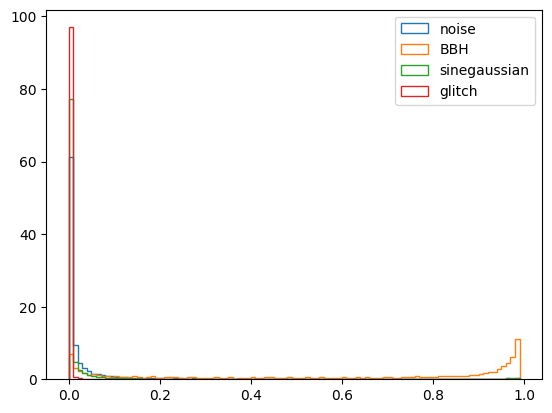

In [104]:
plt.hist(resTest_beforeSM[:nTest][:,2], histtype='step', label = 'noise', bins = bins, density=True)
plt.hist(resTest_beforeSM[nTest : 2 * nTest][:,2], histtype='step', label = 'BBH', bins = bins, density=True)
plt.hist(resTest_beforeSM[2 * nTest:3 * nTest][:,2], histtype='step', label = 'sinegaussian', bins = bins, density=True)
plt.hist(resTest_beforeSM[3 * nTest:][:,2], histtype='step', label = 'glitch', bins = bins, density=True)
plt.legend()

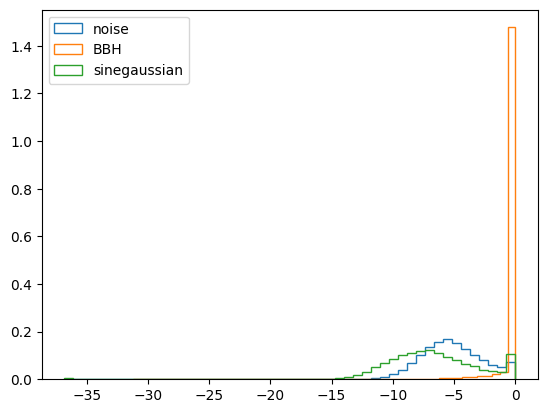

In [116]:
plt.hist(np.log(resTest_beforeSM[:nTest][:,2] + 1e-16), histtype='step', label = 'noise', bins = 50, density=True)
plt.hist(np.log(resTest_beforeSM[nTest : 2 * nTest][:,2]+1e-16), histtype='step', label = 'BBH', bins = 50, density=True)
plt.hist(np.log(resTest_beforeSM[2 * nTest:3 * nTest][:,2] + 1e-16), histtype='step', label = 'sinegaussian', bins = 50, density=True)
# plt.hist(np.log(resTest_beforeSM[3 * nTest:][:,1] + 1e-16), histtype='step', label = 'glitch', bins = 50, density=True)
plt.legend()
# plt.xscale('log')

In [ ]:
(np.argwhere(resTest[:nTest] == 1).shape[1] + np.argwhere(resTest[nTest : 2 * nTest] == 2).shape[1] + np.argwhere().shape[1] + np.argwhere().shape[1])

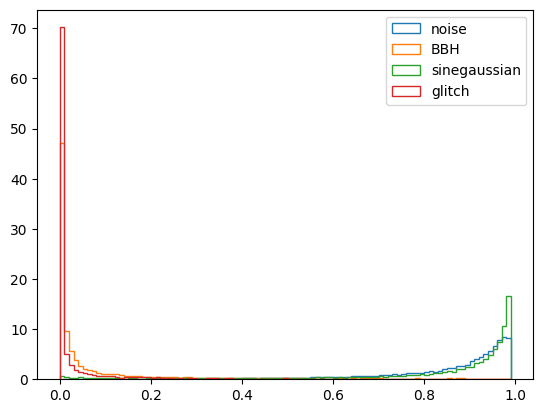

In [129]:
plt.hist(resTest_beforeSM[:nTest][:,1], histtype='step', label = 'noise', bins = bins, density=True)
plt.hist(resTest_beforeSM[nTest : 2 * nTest][:,1], histtype='step', label = 'BBH', bins = bins, density=True)
plt.hist(resTest_beforeSM[2 * nTest:3 * nTest][:,1], histtype='step', label = 'sinegaussian', bins = bins, density=True)
plt.hist(resTest_beforeSM[3 * nTest:][:,1], histtype='step', label = 'glitch', bins = bins, density=True)
plt.legend()

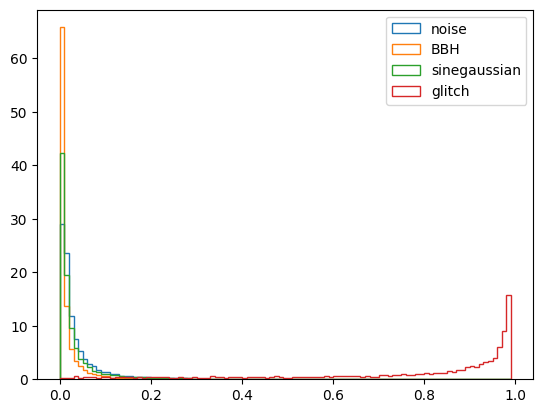

In [130]:
plt.hist(resTest_beforeSM[:nTest][:,0], histtype='step', label = 'noise', bins = bins, density=True)
plt.hist(resTest_beforeSM[nTest : 2 * nTest][:,0], histtype='step', label = 'BBH', bins = bins, density=True)
plt.hist(resTest_beforeSM[2 * nTest:3 * nTest][:,0], histtype='step', label = 'sinegaussian', bins = bins, density=True)
plt.hist(resTest_beforeSM[3 * nTest:][:,0], histtype='step', label = 'glitch', bins = bins, density=True)
plt.legend()

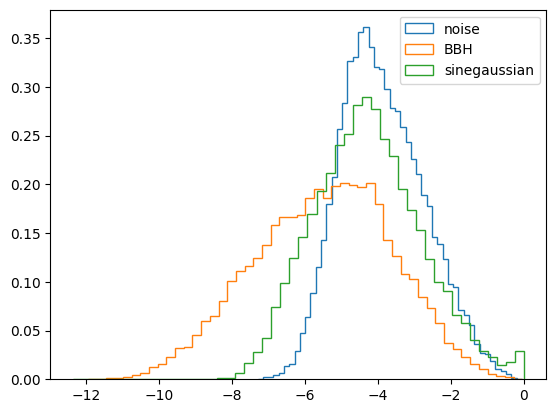

In [133]:
plt.hist(np.log(resTest_beforeSM[:nTest][:,0] + 1e-16), histtype='step', label = 'noise', bins = 50, density=True)
plt.hist(np.log(resTest_beforeSM[nTest : 2 * nTest][:,0]+1e-16), histtype='step', label = 'BBH', bins = 50, density=True)
plt.hist(np.log(resTest_beforeSM[2 * nTest:3 * nTest][:,0] + 1e-16), histtype='step', label = 'sinegaussian', bins = 50, density=True)
# plt.hist(np.log(resTest_beforeSM[3 * nTest:][:,1] + 1e-16), histtype='step', label = 'glitch', bins = 50, density=True)
plt.legend()
# plt.xscale('log')

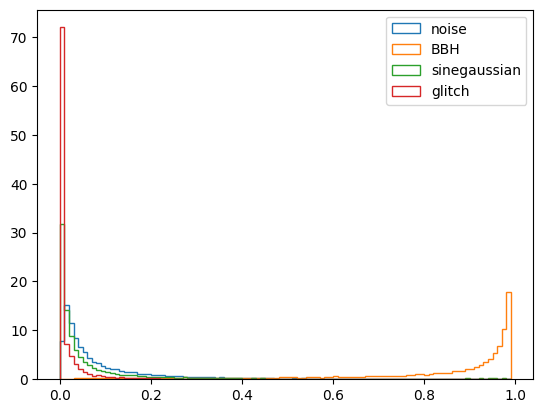

In [131]:
plt.hist(resTest_beforeSM[:nTest][:,2], histtype='step', label = 'noise', bins = bins, density=True)
plt.hist(resTest_beforeSM[nTest : 2 * nTest][:,2], histtype='step', label = 'BBH', bins = bins, density=True)
plt.hist(resTest_beforeSM[2 * nTest:3 * nTest][:,2], histtype='step', label = 'sinegaussian', bins = bins, density=True)
plt.hist(resTest_beforeSM[3 * nTest:][:,2], histtype='step', label = 'glitch', bins = bins, density=True)
plt.legend()

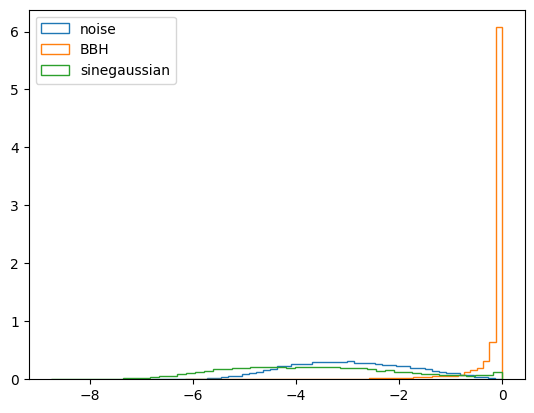

In [132]:
plt.hist(np.log(resTest_beforeSM[:nTest][:,2] + 1e-16), histtype='step', label = 'noise', bins = 50, density=True)
plt.hist(np.log(resTest_beforeSM[nTest : 2 * nTest][:,2]+1e-16), histtype='step', label = 'BBH', bins = 50, density=True)
plt.hist(np.log(resTest_beforeSM[2 * nTest:3 * nTest][:,2] + 1e-16), histtype='step', label = 'sinegaussian', bins = 50, density=True)
# plt.hist(np.log(resTest_beforeSM[3 * nTest:][:,1] + 1e-16), histtype='step', label = 'glitch', bins = 50, density=True)
plt.legend()
# plt.xscale('log')